In [1]:
import os
import torch
import numpy as np
import pandas as pd
import sys
import random
import h5py
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

sys.path.append('../')

from models.smc.src import *
from models.smc.src.crowd_count import *
from models.smc.src.network import *
from models.smc.src.data_loader import ImageDataLoader
from models.smc.src.timer import *
from models.smc.src.evaluate_model import *
from models.smc.src import utils

torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
# Check to see if device can be trained on GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(device)


cuda


In [3]:
# Cuda configurations

torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

current_device = torch.cuda.current_device()
current_device_name = torch.cuda.get_device_name(current_device)
memory_allocated = torch.cuda.memory_allocated()
memory_cached = torch.cuda.memory_reserved()

print(
    f'Using gpu {current_device_name} with device number {current_device}.\n'
    f'Memory allocated = {memory_allocated}\n'
    f'Memory cached = {memory_cached}'
)

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [4]:
try:
    from termcolor import cprint
except ImportError:
    cprint = None


def log_print(text, color=None, on_color=None, attrs=None):
    if cprint is not None:
        cprint(text, color=color, on_color=on_color, attrs=attrs)
    else:
        print(text)

In [5]:
# Directory Configurations

method = 'smc'
dataset_name = 'JHU'
output_dir = f'../output/{method}/saved_models/{dataset_name}'

# Training data path
train_path = '../data/JHU/train/consolidated'
train_gt_path = '../data/JHU/train/gt'

# Validation data path
val_path = '../data/JHU/val/consolidated'
val_gt_path = '../data/JHU/val/gt'



In [6]:
# Create output directory if it doesnt exist

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [7]:
# load model

is_cuda = True  # Determine if we should use the CPU to train or GPU

model = CrowdCounter(is_cuda=is_cuda)  # is_cuda determines if all the input tensors should be converted to cuda tensors
network.weights_normal_init(model, dev=0.01)
model.train()


CrowdCounter(
  (model): SMC(
    (r1): Sequential(
      (0): Conv2d(
        (conv): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu): ReLU(inplace=True)
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Conv2d(
        (conv): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (relu): ReLU(inplace=True)
      )
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(
        (conv): Conv2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (relu): ReLU(inplace=True)
      )
      (5): Conv2d(
        (conv): Conv2d(16, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (relu): ReLU(inplace=True)
      )
    )
    (r2_1): Sequential(
      (0): Conv2d(
        (conv): Conv2d(3, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (relu): ReLU(inplace=True)
      )
      (1): MaxPool2d(kernel_s

In [8]:
# Model parameters

for name, param in model.named_parameters():
    print(f'{name}\t{param.device}\t{param.shape}')

# Print model's state_dict
print("\nModel's state_dict: \n")
for k, v in model.state_dict().items():
    print(k, "\t", v.dtype)

model.r1.0.conv.weight	cpu	torch.Size([16, 3, 9, 9])
model.r1.0.conv.bias	cpu	torch.Size([16])
model.r1.2.conv.weight	cpu	torch.Size([32, 16, 7, 7])
model.r1.2.conv.bias	cpu	torch.Size([32])
model.r1.4.conv.weight	cpu	torch.Size([16, 32, 7, 7])
model.r1.4.conv.bias	cpu	torch.Size([16])
model.r1.5.conv.weight	cpu	torch.Size([8, 16, 7, 7])
model.r1.5.conv.bias	cpu	torch.Size([8])
model.r2_1.0.conv.weight	cpu	torch.Size([20, 3, 7, 7])
model.r2_1.0.conv.bias	cpu	torch.Size([20])
model.r2_1.2.conv.weight	cpu	torch.Size([40, 20, 5, 5])
model.r2_1.2.conv.bias	cpu	torch.Size([40])
model.r2_1.4.conv.weight	cpu	torch.Size([20, 40, 5, 5])
model.r2_1.4.conv.bias	cpu	torch.Size([20])
model.r2_1.5.conv.weight	cpu	torch.Size([10, 20, 5, 5])
model.r2_1.5.conv.bias	cpu	torch.Size([10])
model.r2_2.0.conv.weight	cpu	torch.Size([24, 3, 5, 5])
model.r2_2.0.conv.bias	cpu	torch.Size([24])
model.r2_2.2.conv.weight	cpu	torch.Size([48, 24, 3, 3])
model.r2_2.2.conv.bias	cpu	torch.Size([48])
model.r2_2.4.conv.wei

In [9]:
# Change model weights tensors to be cuda tensors if is_cuda is true and cuda is available

if is_cuda and torch.cuda.is_available():
    print("Changing to cuda weights")
    model.cuda()

Changing to cuda weights


In [10]:
#training configuration

disp_interval = 1

train_loss = 0
re_cnt = False
t = Timer()
t.tic()

# Set initial values
best_mae, best_mse, best_epoch, best_mape = 999999, 999999, 0, 9999999


In [11]:
# Hyperparameters

learning_rate = 0.0001
epochs = 100

# construct an optimizer

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=learning_rate)


In [12]:
# Load the images, take note the num_pool argument

data_loader = ImageDataLoader(train_path, shuffle=False, pre_load=False, num_pool = 2, size=100)
data_loader_val = ImageDataLoader(val_path, shuffle=False, pre_load=False, num_pool = 2, size=40)

# Saved weights
save_name = None


In [13]:
from torch.autograd import Variable

current_date = datetime.now()
 
# dd/mm/YY H:M:S
cd_string = current_date.strftime("%d/%m/%Y %H:%M:%S")
#Tensorboard  config
use_tensorboard = False

writer = SummaryWriter(f'../output/tensorboard/runs/{learning_rate}_{epochs}_{cd_string}')

# Add model to tensorboard
dummy_input = data_loader.get_test_input()

#writer.add_graph(model.get_model(), Variable(dummy_input['data'].type(torch.FloatTensor)).cuda())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [14]:
for epoch in range(1, epochs+1):    
    train_loss = 0.0
    model.train()
    for id, blob in enumerate(data_loader, 1):  
        im_data = blob['data']
        gt_data = blob['gt_density']
        metadata = blob['metadata']

        # Forward pass + backward pass + optimise
        try:
            density_map = model(im_data, gt_data)
            loss = model.loss
            optimizer.zero_grad()
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()

            # Write to tensorboard
            train_loss += loss.item()

            if id % disp_interval == 0:            
                gt_count = torch.sum(gt_data)                
                et_count = torch.sum(density_map)
                #utils.save_results(im_data,gt_data,density_map, output_dir)
                log_text = '[%3d, %3d] Image: %s, Actual Count: %6d, Estimated Count: %6.3f' % (epoch, id, metadata['img_path'], gt_count, et_count)
                log_print(log_text, color='green', attrs=['bold'])

        except Exception as e:
            #print(e)
            #print('continuing... image path: {}'.format(metadata['img_path']))
            continue
        #if id == 10: break

    # Overwrite the current model weights
    current_model = f'{method}_{learning_rate}.h5'
    save_name = os.path.join(output_dir, current_model)
    network.save_net(save_name, model)
            
    # Evaluate the mae and mse results by doing a forward pass against the validation dataset i.e data_loader_val for
    # each epoch
    MAEcrowddensity, MSEcrowddensity, MAPEcrowddensity, MAEweather, MSEweather, MAPEweather, MAE, MSE, RMSE, MAPE = evaluate_model(save_name, data_loader_val, is_cuda=is_cuda)
    
    # Pocket algorithm: Check to see if the current epoch mae is better than the best recorded one,
    # If it is, then overwrite the current best .h5 weights file
    if MAE < best_mae:
        # Save the new best mae and mse
        best_mae = MAE
        best_epoch = epoch
        best_model = f'best_MAE_epoch_{epoch}_{method}_{learning_rate}.h5'

        # Overwrite or create a new file for the best model for this learning rate
        save_name = os.path.join(output_dir, best_model)
        best_mae_path = save_name
        network.save_net(save_name, model)
        
    if MSE < best_mse:
        # Save the new best mae and mse
        best_mse = MSE
        best_epoch = epoch
        best_model = f'best_MSE_epoch_{epoch}_{method}_{learning_rate}.h5'

        # Overwrite or create a new file for the best model for this learning rate
        save_name = os.path.join(output_dir, best_model)
        best_mse_path = save_name
        network.save_net(save_name, model)
        
    if MAPE < best_mape:
        # Save the new best mae and mse
        best_mape = MAPE
        best_epoch = epoch
        best_model = f'best_MAPE_epoch_{epoch}_{method}_{learning_rate}.h5'

        # Overwrite or create a new file for the best model for this learning rate
        save_name = os.path.join(output_dir, best_model)
        best_mape_path = save_name
        network.save_net(save_name, model)
        
    # Print out the best epoch that beat the current best mae   
    log_text = 'EPOCH: %4d, Val MAE: %.3f, Val MSE: %.3f, Val RMSE: %.3f, Val MAPE: %.3f' % (epoch, MAE, MSE, RMSE, MAPE)
    log_print(log_text, color='blue', attrs=['bold'])

    # Save the results to tensorboard for each epoch
    if use_tensorboard:
        
        # overall segment
        writer.add_scalar("Overall/Val MAE", MAE, epoch)
        writer.add_scalar("Overall/Val MSE", MSE, epoch)
        writer.add_scalar("Overall/Val RMSE", RMSE, epoch)
        writer.add_scalar("Overall/Val MAPE", MAPE, epoch)
        writer.add_scalar("Overall/Train Loss", train_loss / data_loader.get_num_samples(), epoch)
        
        # crowd density segment
        writer.add_scalar('Crowd Density/High/MAE', MAEcrowddensity['High'], epoch)
        writer.add_scalar('Crowd Density/High/MSE', MSEcrowddensity['High'], epoch)
        writer.add_scalar('Crowd Density/High/RMSE', np.sqrt(MSEcrowddensity['High']), epoch)
        writer.add_scalar('Crowd Density/High/MAPE', MAPEcrowddensity['High'], epoch)
        
        writer.add_scalar('Crowd Density/Med/MAE', MAEcrowddensity['Med'], epoch)
        writer.add_scalar('Crowd Density/Med/MSE', MSEcrowddensity['Med'], epoch)
        writer.add_scalar('Crowd Density/Med/RMSE', np.sqrt(MSEcrowddensity['Med']), epoch)
        writer.add_scalar('Crowd Density/Med/MAPE', MAPEcrowddensity['Med'], epoch)
        
        writer.add_scalar('Crowd Density/Low/MAE', MAEcrowddensity['Low'], epoch)
        writer.add_scalar('Crowd Density/Low/MSE', MSEcrowddensity['Low'], epoch)
        writer.add_scalar('Crowd Density/Low/RMSE', np.sqrt(MSEcrowddensity['Low']), epoch)
        writer.add_scalar('Crowd Density/Low/MAPE', MAPEcrowddensity['Low'], epoch)
        
        # weather segment
        writer.add_scalar('Weather/No Degradation/MAE', MAEweather['None'], epoch)
        writer.add_scalar('Weather/No Degradation/MSE', MSEweather['None'], epoch)
        writer.add_scalar('Weather/No Degradation/RMSE', np.sqrt(MSEweather['None']), epoch)
        writer.add_scalar('Weather/No Degradation/MAPE', MAPEweather['None'], epoch)
        
        writer.add_scalar('Weather/Fog/MAE', MAEweather['Fog'], epoch)
        writer.add_scalar('Weather/Fog/MSE', MSEweather['Fog'], epoch)
        writer.add_scalar('Weather/Fog/RMSE', np.sqrt(MSEweather['Fog']), epoch)
        writer.add_scalar('Weather/Fog/MAPE', MAPEweather['Fog'], epoch)
        
        writer.add_scalar('Weather/Rain/MAE', MAEweather['Rain'], epoch)
        writer.add_scalar('Weather/Rain/MSE', MSEweather['Rain'], epoch)
        writer.add_scalar('Weather/Rain/RMSE', np.sqrt(MSEweather['Rain']), epoch)
        writer.add_scalar('Weather/Rain/MAPE', MAPEweather['Rain'], epoch)
        
        writer.add_scalar('Weather/Snow/MAE', MAEweather['Snow'], epoch)
        writer.add_scalar('Weather/Snow/MSE', MSEweather['Snow'], epoch)
        writer.add_scalar('Weather/Snow/RMSE', np.sqrt(MSEweather['Snow']), epoch)
        writer.add_scalar('Weather/Snow/MAPE', MAPEweather['Snow'], epoch)

[  1,   1] Image: 0714, Actual Count:     40, Estimated Count:  0.018
[  1,   2] Image: 0424, Actual Count:     76, Estimated Count:  0.789
[  1,   3] Image: 0272, Actual Count:    757, Estimated Count: 14.816
[  1,   4] Image: 0901, Actual Count:    839, Estimated Count: 48.248
[  1,   5] Image: 0010, Actual Count:    455, Estimated Count: 48.763
[  1,   6] Image: 0315, Actual Count:     31, Estimated Count: 37.195
[  1,   8] Image: 0103, Actual Count:     47, Estimated Count: 74.027
[  1,   9] Image: 0255, Actual Count:  25790, Estimated Count: 163.530
[  1,  10] Image: 0771, Actual Count:     21, Estimated Count:  9.039
[  1,  11] Image: 0180, Actual Count:    120, Estimated Count: 13.519
[  1,  12] Image: 0151, Actual Count:    184, Estimated Count: 319.485
[  1,  13] Image: 0909, Actual Count:     41, Estimated Count: 10.517
[  1,  14] Image: 0230, Actual Count:     95, Estimated Count: 17.838
[  1,  15] Image: 0314, Actual Count:     81, Estimated Count: 52.104
[  1,  16] Image: 

[  2,  10] Image: 0771, Actual Count:     21, Estimated Count: 19.624
[  2,  11] Image: 0180, Actual Count:    120, Estimated Count: 30.706
[  2,  12] Image: 0151, Actual Count:    184, Estimated Count: 742.984
[  2,  13] Image: 0909, Actual Count:     41, Estimated Count: 24.461
[  2,  14] Image: 0230, Actual Count:     95, Estimated Count: 45.301
[  2,  15] Image: 0314, Actual Count:     81, Estimated Count: 130.856
[  2,  16] Image: 0517, Actual Count:     32, Estimated Count: 89.495
[  2,  17] Image: 0767, Actual Count:    125, Estimated Count: 261.181
[  2,  18] Image: 0933, Actual Count:     54, Estimated Count: 56.447
[  2,  19] Image: 0708, Actual Count:      6, Estimated Count: 151.042
[  2,  20] Image: 0474, Actual Count:     50, Estimated Count: 402.833
[  2,  21] Image: 0971, Actual Count:     47, Estimated Count: 289.439
[  2,  22] Image: 0457, Actual Count:     92, Estimated Count: 58.433
[  2,  23] Image: 0097, Actual Count:     54, Estimated Count: 27.247
[  2,  24] Ima

[  3,  17] Image: 0767, Actual Count:    125, Estimated Count: 240.740
[  3,  18] Image: 0933, Actual Count:     54, Estimated Count: 53.519
[  3,  19] Image: 0708, Actual Count:      6, Estimated Count: 140.534
[  3,  20] Image: 0474, Actual Count:     50, Estimated Count: 385.039
[  3,  21] Image: 0971, Actual Count:     47, Estimated Count: 272.246
[  3,  22] Image: 0457, Actual Count:     92, Estimated Count: 53.158
[  3,  23] Image: 0097, Actual Count:     54, Estimated Count: 27.259
[  3,  24] Image: 0415, Actual Count:    519, Estimated Count: 236.188
[  4,   5] Image: 0010, Actual Count:    455, Estimated Count: 200.849
[  4,   6] Image: 0315, Actual Count:     31, Estimated Count: 124.028
[  4,   7] Image: 0413, Actual Count:    813, Estimated Count: 570.227
[  4,   8] Image: 0103, Actual Count:     47, Estimated Count: 181.496
[  4,   9] Image: 0255, Actual Count:  25790, Estimated Count: 298.718
[  4,  10] Image: 0771, Actual Count:     21, Estimated Count: 22.530
[  4,  11]

[  5,   4] Image: 0901, Actual Count:    839, Estimated Count: 233.880
[  5,   5] Image: 0010, Actual Count:    455, Estimated Count: 215.949
[  5,   6] Image: 0315, Actual Count:     31, Estimated Count: 144.655
[  5,   7] Image: 0413, Actual Count:    813, Estimated Count: 680.459
[  5,   8] Image: 0103, Actual Count:     47, Estimated Count: 206.684
[  5,   9] Image: 0255, Actual Count:  25790, Estimated Count: 329.953
[  5,  10] Image: 0771, Actual Count:     21, Estimated Count: 27.278
[  5,  11] Image: 0180, Actual Count:    120, Estimated Count: 36.778
[  5,  12] Image: 0151, Actual Count:    184, Estimated Count: 836.920
[  5,  13] Image: 0909, Actual Count:     41, Estimated Count: 27.943
[  5,  14] Image: 0230, Actual Count:     95, Estimated Count: 38.866
[  5,  15] Image: 0314, Actual Count:     81, Estimated Count: 114.133
[  5,  16] Image: 0517, Actual Count:     32, Estimated Count: 83.650
[  5,  17] Image: 0767, Actual Count:    125, Estimated Count: 298.184
[  5,  18] 

[  6,  80] Image: 0037, Actual Count:     74, Estimated Count: 51.086
[  6,  82] Image: 0139, Actual Count:     36, Estimated Count: 69.038
[  6,  83] Image: 0938, Actual Count:    138, Estimated Count: 125.816
[  6,  84] Image: 0323, Actual Count:     39, Estimated Count:  9.048
[  6,  85] Image: 0913, Actual Count:   1224, Estimated Count: 65.413
[  6,  86] Image: 0682, Actual Count:     36, Estimated Count: 228.827
[  6,  87] Image: 0267, Actual Count:     63, Estimated Count: 56.479
[  6,  88] Image: 0383, Actual Count:    220, Estimated Count: 32.557
[  6,  89] Image: 0607, Actual Count:     16, Estimated Count: 43.458
[  6,  90] Image: 0428, Actual Count:     63, Estimated Count: 37.137
[  6,  91] Image: 0175, Actual Count:     85, Estimated Count: 54.671
[  6,  92] Image: 0251, Actual Count:     74, Estimated Count: 22.694
[  6,  93] Image: 0697, Actual Count:    107, Estimated Count: 498.854
[  7,  27] Image: 0636, Actual Count:    600, Estimated Count: 87.633
[  7,  28] Image:

[  8,  20] Image: 0474, Actual Count:     50, Estimated Count: 295.990
[  8,  21] Image: 0971, Actual Count:     47, Estimated Count: 335.340
[  8,  22] Image: 0457, Actual Count:     92, Estimated Count: 48.416
[  8,  23] Image: 0097, Actual Count:     54, Estimated Count: 56.772
[  8,  24] Image: 0415, Actual Count:    519, Estimated Count: 336.353
[  8,  25] Image: 0630, Actual Count:    570, Estimated Count: 279.290
[  8,  27] Image: 0636, Actual Count:    600, Estimated Count: 89.014
[  8,  28] Image: 0724, Actual Count:   1229, Estimated Count: 195.246
[  8,  29] Image: 0032, Actual Count:    158, Estimated Count: 32.859
[  8,  30] Image: 0784, Actual Count:   1643, Estimated Count: 349.900
[  8,  32] Image: 0487, Actual Count:    100, Estimated Count: 82.148
[  8,  33] Image: 0224, Actual Count:     63, Estimated Count: 66.739
[  8,  34] Image: 0665, Actual Count:    655, Estimated Count: 151.693
[  8,  35] Image: 0040, Actual Count:     20, Estimated Count: 554.264
[  8,  36] I

[  9,  27] Image: 0636, Actual Count:    600, Estimated Count: 91.394
[  9,  28] Image: 0724, Actual Count:   1229, Estimated Count: 200.032
[  9,  29] Image: 0032, Actual Count:    158, Estimated Count: 34.688
[  9,  30] Image: 0784, Actual Count:   1643, Estimated Count: 353.350
[  9,  32] Image: 0487, Actual Count:    100, Estimated Count: 80.314
[  9,  33] Image: 0224, Actual Count:     63, Estimated Count: 66.023
[  9,  34] Image: 0665, Actual Count:    655, Estimated Count: 149.970
[  9,  35] Image: 0040, Actual Count:     20, Estimated Count: 542.821
[  9,  36] Image: 0914, Actual Count:     19, Estimated Count: 46.100
[  9,  37] Image: 0851, Actual Count:    520, Estimated Count: 63.428
[  9,  38] Image: 0345, Actual Count:    221, Estimated Count: 30.868
[  9,  39] Image: 0018, Actual Count:     80, Estimated Count: 103.074
[  9,  40] Image: 0373, Actual Count:     25, Estimated Count: 58.822
[  9,  41] Image: 0809, Actual Count:     38, Estimated Count: 67.480
[  9,  42] Imag

[ 10,  34] Image: 0665, Actual Count:    655, Estimated Count: 153.944
[ 10,  35] Image: 0040, Actual Count:     20, Estimated Count: 459.736
[ 10,  36] Image: 0914, Actual Count:     19, Estimated Count: 49.170
[ 10,  37] Image: 0851, Actual Count:    520, Estimated Count: 66.021
[ 10,  38] Image: 0345, Actual Count:    221, Estimated Count: 31.127
[ 10,  39] Image: 0018, Actual Count:     80, Estimated Count: 103.396
[ 10,  40] Image: 0373, Actual Count:     25, Estimated Count: 46.198
[ 10,  41] Image: 0809, Actual Count:     38, Estimated Count: 69.075
[ 10,  42] Image: 0543, Actual Count:    123, Estimated Count: 298.307
[ 10,  44] Image: 0945, Actual Count:     52, Estimated Count: 117.497
[ 10,  45] Image: 0369, Actual Count:     50, Estimated Count: 239.859
[ 10,  46] Image: 0073, Actual Count:    586, Estimated Count: 507.176
[ 10,  47] Image: 0248, Actual Count:     26, Estimated Count: 26.468
[ 10,  48] Image: 0295, Actual Count:     41, Estimated Count: 34.213
[ 10,  50] Im

[ 11,  40] Image: 0373, Actual Count:     25, Estimated Count: 60.962
[ 11,  41] Image: 0809, Actual Count:     38, Estimated Count: 75.017
[ 11,  42] Image: 0543, Actual Count:    123, Estimated Count: 320.122
[ 11,  44] Image: 0945, Actual Count:     52, Estimated Count: 134.016
[ 11,  45] Image: 0369, Actual Count:     50, Estimated Count: 245.285
[ 11,  46] Image: 0073, Actual Count:    586, Estimated Count: 613.700
[ 11,  47] Image: 0248, Actual Count:     26, Estimated Count: 32.057
[ 11,  48] Image: 0295, Actual Count:     41, Estimated Count: 38.284
[ 11,  50] Image: 0302, Actual Count:     89, Estimated Count: 91.167
[ 11,  51] Image: 0246, Actual Count:     62, Estimated Count: 19.703
[ 11,  52] Image: 0313, Actual Count:    345, Estimated Count: 176.309
[ 11,  53] Image: 0478, Actual Count:     27, Estimated Count: 102.902
[ 11,  54] Image: 0815, Actual Count:    204, Estimated Count: 38.100
[ 11,  55] Image: 0556, Actual Count:     73, Estimated Count: 235.286
[ 11,  56] Im

[ 12,  48] Image: 0295, Actual Count:     41, Estimated Count: 42.969
[ 12,  50] Image: 0302, Actual Count:     89, Estimated Count: 85.740
[ 12,  51] Image: 0246, Actual Count:     62, Estimated Count: 20.719
[ 12,  52] Image: 0313, Actual Count:    345, Estimated Count: 166.997
[ 12,  53] Image: 0478, Actual Count:     27, Estimated Count: 107.527
[ 12,  54] Image: 0815, Actual Count:    204, Estimated Count: 43.379
[ 12,  55] Image: 0556, Actual Count:     73, Estimated Count: 212.222
[ 12,  56] Image: 0585, Actual Count:     22, Estimated Count: 99.314
[ 12,  57] Image: 0870, Actual Count:     45, Estimated Count: 233.851
[ 12,  58] Image: 0888, Actual Count:     47, Estimated Count: 146.137
[ 12,  59] Image: 0560, Actual Count:    229, Estimated Count: 62.461
[ 12,  60] Image: 0845, Actual Count:   1555, Estimated Count: 242.554
[ 12,  61] Image: 0974, Actual Count:    560, Estimated Count: 120.133
[ 12,  62] Image: 0334, Actual Count:     60, Estimated Count: 136.123
[ 12,  63] I

[ 13,  55] Image: 0556, Actual Count:     73, Estimated Count: 143.900
[ 13,  56] Image: 0585, Actual Count:     22, Estimated Count: 82.380
[ 13,  57] Image: 0870, Actual Count:     45, Estimated Count: 135.142
[ 13,  58] Image: 0888, Actual Count:     47, Estimated Count: 116.686
[ 13,  59] Image: 0560, Actual Count:    229, Estimated Count: 40.572
[ 13,  60] Image: 0845, Actual Count:   1555, Estimated Count: 235.955
[ 13,  61] Image: 0974, Actual Count:    560, Estimated Count: 56.403
[ 13,  62] Image: 0334, Actual Count:     60, Estimated Count: 101.748
[ 13,  63] Image: 0575, Actual Count:    198, Estimated Count: 110.846
[ 13,  64] Image: 0100, Actual Count:    418, Estimated Count: 12.414
[ 13,  65] Image: 0336, Actual Count:     30, Estimated Count:  8.521
[ 13,  66] Image: 0284, Actual Count:     74, Estimated Count: 42.366
[ 13,  67] Image: 0903, Actual Count:     81, Estimated Count: 74.472
[ 13,  68] Image: 0450, Actual Count:    288, Estimated Count: 14.068
[ 13,  69] Ima

[ 14,  62] Image: 0334, Actual Count:     60, Estimated Count: 111.992
[ 14,  63] Image: 0575, Actual Count:    198, Estimated Count: 101.922
[ 14,  64] Image: 0100, Actual Count:    418, Estimated Count: 20.611
[ 14,  65] Image: 0336, Actual Count:     30, Estimated Count:  7.413
[ 14,  66] Image: 0284, Actual Count:     74, Estimated Count: 67.194
[ 14,  67] Image: 0903, Actual Count:     81, Estimated Count: 103.927
[ 14,  68] Image: 0450, Actual Count:    288, Estimated Count: 20.913
[ 14,  69] Image: 0776, Actual Count:    141, Estimated Count: 20.688
[ 14,  70] Image: 0075, Actual Count:    295, Estimated Count: 216.101
[ 14,  71] Image: 0029, Actual Count:     76, Estimated Count: 12.480
[ 14,  73] Image: 0477, Actual Count:    125, Estimated Count: 113.404
[ 14,  74] Image: 0500, Actual Count:     21, Estimated Count: 26.759
[ 14,  75] Image: 0827, Actual Count:     94, Estimated Count: 15.189
[ 14,  76] Image: 0290, Actual Count:     44, Estimated Count: 39.192
[ 14,  77] Imag

[ 15,  69] Image: 0776, Actual Count:    141, Estimated Count: 23.206
[ 15,  70] Image: 0075, Actual Count:    295, Estimated Count: 214.791
[ 15,  71] Image: 0029, Actual Count:     76, Estimated Count: 14.302
[ 15,  73] Image: 0477, Actual Count:    125, Estimated Count: 116.732
[ 15,  74] Image: 0500, Actual Count:     21, Estimated Count: 26.048
[ 15,  75] Image: 0827, Actual Count:     94, Estimated Count: 18.331
[ 15,  76] Image: 0290, Actual Count:     44, Estimated Count: 40.767
[ 15,  77] Image: 0472, Actual Count:     23, Estimated Count: 21.134
[ 15,  78] Image: 0621, Actual Count:   1348, Estimated Count: 781.523
[ 15,  79] Image: 0146, Actual Count:     73, Estimated Count: 85.997
[ 15,  80] Image: 0037, Actual Count:     74, Estimated Count: 60.638
[ 15,  82] Image: 0139, Actual Count:     36, Estimated Count: 71.332
[ 15,  83] Image: 0938, Actual Count:    138, Estimated Count: 93.044
[ 15,  84] Image: 0323, Actual Count:     39, Estimated Count: 13.039
[ 15,  85] Image:

[ 16,  77] Image: 0472, Actual Count:     23, Estimated Count:  1.995
[ 16,  78] Image: 0621, Actual Count:   1348, Estimated Count: 639.648
[ 16,  79] Image: 0146, Actual Count:     73, Estimated Count: 44.155
[ 16,  80] Image: 0037, Actual Count:     74, Estimated Count:  7.607
[ 16,  82] Image: 0139, Actual Count:     36, Estimated Count: 43.847
[ 16,  83] Image: 0938, Actual Count:    138, Estimated Count: 56.276
[ 16,  84] Image: 0323, Actual Count:     39, Estimated Count:  6.429
[ 16,  85] Image: 0913, Actual Count:   1224, Estimated Count: 66.669
[ 16,  86] Image: 0682, Actual Count:     36, Estimated Count: 154.261
[ 16,  87] Image: 0267, Actual Count:     63, Estimated Count: 43.889
[ 16,  88] Image: 0383, Actual Count:    220, Estimated Count: 13.703
[ 16,  89] Image: 0607, Actual Count:     16, Estimated Count: 14.952
[ 16,  90] Image: 0428, Actual Count:     63, Estimated Count:  4.369
[ 16,  91] Image: 0175, Actual Count:     85, Estimated Count: 12.408
[ 16,  92] Image: 

[ 17,  85] Image: 0913, Actual Count:   1224, Estimated Count: 65.575
[ 17,  86] Image: 0682, Actual Count:     36, Estimated Count: 196.960
[ 17,  87] Image: 0267, Actual Count:     63, Estimated Count: 55.193
[ 17,  88] Image: 0383, Actual Count:    220, Estimated Count: 23.696
[ 17,  89] Image: 0607, Actual Count:     16, Estimated Count: 33.730
[ 17,  90] Image: 0428, Actual Count:     63, Estimated Count: 20.454
[ 17,  91] Image: 0175, Actual Count:     85, Estimated Count: 34.198
[ 17,  92] Image: 0251, Actual Count:     74, Estimated Count: 27.512
[ 17,  93] Image: 0697, Actual Count:    107, Estimated Count: 407.877
[ 17,  94] Image: 0118, Actual Count:     37, Estimated Count: 48.796
[ 17,  96] Image: 0292, Actual Count:     84, Estimated Count: 38.577
[ 17,  97] Image: 0960, Actual Count:    183, Estimated Count: 56.155
[ 17,  98] Image: 0206, Actual Count:     77, Estimated Count: 65.344
EPOCH:   17, Val MAE: 257.475, Val MSE: 548867.375, Val RMSE: 740.856, Val MAPE: 1.277
[

[ 18,  92] Image: 0251, Actual Count:     74, Estimated Count: 25.052
[ 18,  93] Image: 0697, Actual Count:    107, Estimated Count: 437.467
[ 18,  94] Image: 0118, Actual Count:     37, Estimated Count: 51.837
[ 18,  96] Image: 0292, Actual Count:     84, Estimated Count: 36.244
[ 18,  97] Image: 0960, Actual Count:    183, Estimated Count: 45.532
[ 18,  98] Image: 0206, Actual Count:     77, Estimated Count: 66.475
EPOCH:   18, Val MAE: 264.809, Val MSE: 581006.562, Val RMSE: 762.238, Val MAPE: 1.246
[ 19,   1] Image: 0714, Actual Count:     40, Estimated Count: 47.304
[ 19,   2] Image: 0424, Actual Count:     76, Estimated Count: 12.802
[ 19,   3] Image: 0272, Actual Count:    757, Estimated Count: 148.521
[ 19,   4] Image: 0901, Actual Count:    839, Estimated Count: 251.522
[ 19,   5] Image: 0010, Actual Count:    455, Estimated Count: 267.732
[ 19,   6] Image: 0315, Actual Count:     31, Estimated Count: 132.534
[ 19,   7] Image: 0413, Actual Count:    813, Estimated Count: 588.2

[ 20,   1] Image: 0714, Actual Count:     40, Estimated Count: 64.002
[ 20,   2] Image: 0424, Actual Count:     76, Estimated Count: 15.123
[ 20,   3] Image: 0272, Actual Count:    757, Estimated Count: 163.628
[ 20,   4] Image: 0901, Actual Count:    839, Estimated Count: 397.216
[ 20,   5] Image: 0010, Actual Count:    455, Estimated Count: 352.781
[ 20,   6] Image: 0315, Actual Count:     31, Estimated Count: 141.715
[ 20,   7] Image: 0413, Actual Count:    813, Estimated Count: 666.381
[ 20,   8] Image: 0103, Actual Count:     47, Estimated Count: 171.270
[ 20,   9] Image: 0255, Actual Count:  25790, Estimated Count: 1565.592
[ 20,  10] Image: 0771, Actual Count:     21, Estimated Count: 33.201
[ 20,  11] Image: 0180, Actual Count:    120, Estimated Count: 43.927
[ 20,  12] Image: 0151, Actual Count:    184, Estimated Count: 812.318
[ 20,  13] Image: 0909, Actual Count:     41, Estimated Count: 53.113
[ 20,  14] Image: 0230, Actual Count:     95, Estimated Count: 98.682
[ 20,  15] 

[ 21,   7] Image: 0413, Actual Count:    813, Estimated Count: 489.338
[ 21,   8] Image: 0103, Actual Count:     47, Estimated Count: 93.766
[ 21,   9] Image: 0255, Actual Count:  25790, Estimated Count: 1912.635
[ 21,  10] Image: 0771, Actual Count:     21, Estimated Count: 23.218
[ 21,  11] Image: 0180, Actual Count:    120, Estimated Count: 31.842
[ 21,  12] Image: 0151, Actual Count:    184, Estimated Count: 519.037
[ 21,  13] Image: 0909, Actual Count:     41, Estimated Count: 40.845
[ 21,  14] Image: 0230, Actual Count:     95, Estimated Count: 73.696
[ 21,  15] Image: 0314, Actual Count:     81, Estimated Count: 101.832
[ 21,  16] Image: 0517, Actual Count:     32, Estimated Count: 51.408
[ 21,  17] Image: 0767, Actual Count:    125, Estimated Count: 367.604
[ 21,  18] Image: 0933, Actual Count:     54, Estimated Count: 232.356
[ 21,  19] Image: 0708, Actual Count:      6, Estimated Count: 96.558
[ 21,  20] Image: 0474, Actual Count:     50, Estimated Count: 269.603
[ 21,  21] I

[ 22,  14] Image: 0230, Actual Count:     95, Estimated Count: 79.831
[ 22,  15] Image: 0314, Actual Count:     81, Estimated Count: 102.223
[ 22,  16] Image: 0517, Actual Count:     32, Estimated Count: 50.844
[ 22,  17] Image: 0767, Actual Count:    125, Estimated Count: 383.830
[ 22,  18] Image: 0933, Actual Count:     54, Estimated Count: 258.071
[ 22,  19] Image: 0708, Actual Count:      6, Estimated Count: 100.660
[ 22,  20] Image: 0474, Actual Count:     50, Estimated Count: 273.376
[ 22,  21] Image: 0971, Actual Count:     47, Estimated Count: 619.654
[ 22,  22] Image: 0457, Actual Count:     92, Estimated Count: 70.760
[ 22,  23] Image: 0097, Actual Count:     54, Estimated Count: 126.177
[ 22,  24] Image: 0415, Actual Count:    519, Estimated Count: 671.573
[ 22,  25] Image: 0630, Actual Count:    570, Estimated Count: 587.782
[ 22,  27] Image: 0636, Actual Count:    600, Estimated Count: 234.453
[ 22,  28] Image: 0724, Actual Count:   1229, Estimated Count: 604.934
[ 22,  29

[ 23,  21] Image: 0971, Actual Count:     47, Estimated Count: 615.557
[ 23,  22] Image: 0457, Actual Count:     92, Estimated Count: 70.677
[ 23,  23] Image: 0097, Actual Count:     54, Estimated Count: 127.744
[ 23,  24] Image: 0415, Actual Count:    519, Estimated Count: 671.474
[ 23,  25] Image: 0630, Actual Count:    570, Estimated Count: 595.015
[ 23,  27] Image: 0636, Actual Count:    600, Estimated Count: 238.899
[ 23,  28] Image: 0724, Actual Count:   1229, Estimated Count: 624.321
[ 23,  29] Image: 0032, Actual Count:    158, Estimated Count: 157.265
[ 23,  30] Image: 0784, Actual Count:   1643, Estimated Count: 1027.309
[ 23,  32] Image: 0487, Actual Count:    100, Estimated Count: 103.445
[ 23,  33] Image: 0224, Actual Count:     63, Estimated Count: 145.753
[ 23,  34] Image: 0665, Actual Count:    655, Estimated Count: 322.364
[ 23,  35] Image: 0040, Actual Count:     20, Estimated Count: 338.662
[ 23,  36] Image: 0914, Actual Count:     19, Estimated Count: 78.944
[ 23,  

[ 24,  30] Image: 0784, Actual Count:   1643, Estimated Count: 1050.630
[ 24,  32] Image: 0487, Actual Count:    100, Estimated Count: 103.417
[ 24,  33] Image: 0224, Actual Count:     63, Estimated Count: 149.356
[ 24,  34] Image: 0665, Actual Count:    655, Estimated Count: 331.800
[ 24,  35] Image: 0040, Actual Count:     20, Estimated Count: 336.614
[ 24,  36] Image: 0914, Actual Count:     19, Estimated Count: 80.324
[ 24,  37] Image: 0851, Actual Count:    520, Estimated Count: 127.919
[ 24,  38] Image: 0345, Actual Count:    221, Estimated Count: 46.927
[ 24,  39] Image: 0018, Actual Count:     80, Estimated Count: 54.786
[ 24,  40] Image: 0373, Actual Count:     25, Estimated Count: 21.866
[ 24,  41] Image: 0809, Actual Count:     38, Estimated Count: 87.274
[ 24,  42] Image: 0543, Actual Count:    123, Estimated Count: 166.856
[ 24,  44] Image: 0945, Actual Count:     52, Estimated Count: 33.450
[ 24,  45] Image: 0369, Actual Count:     50, Estimated Count: 184.715
[ 24,  46] 

[ 25,  39] Image: 0018, Actual Count:     80, Estimated Count: 48.855
[ 25,  40] Image: 0373, Actual Count:     25, Estimated Count: 15.984
[ 25,  41] Image: 0809, Actual Count:     38, Estimated Count: 82.176
[ 25,  42] Image: 0543, Actual Count:    123, Estimated Count: 143.023
[ 25,  44] Image: 0945, Actual Count:     52, Estimated Count: 24.521
[ 25,  45] Image: 0369, Actual Count:     50, Estimated Count: 174.248
[ 25,  46] Image: 0073, Actual Count:    586, Estimated Count: 93.765
[ 25,  47] Image: 0248, Actual Count:     26, Estimated Count:  7.977
[ 25,  48] Image: 0295, Actual Count:     41, Estimated Count: 34.187
[ 25,  50] Image: 0302, Actual Count:     89, Estimated Count: 42.818
[ 25,  51] Image: 0246, Actual Count:     62, Estimated Count: 16.394
[ 25,  52] Image: 0313, Actual Count:    345, Estimated Count: 29.124
[ 25,  53] Image: 0478, Actual Count:     27, Estimated Count: 63.671
[ 25,  54] Image: 0815, Actual Count:    204, Estimated Count: 54.147
[ 25,  55] Image: 

[ 26,  48] Image: 0295, Actual Count:     41, Estimated Count: 31.939
[ 26,  50] Image: 0302, Actual Count:     89, Estimated Count: 43.808
[ 26,  51] Image: 0246, Actual Count:     62, Estimated Count: 17.080
[ 26,  52] Image: 0313, Actual Count:    345, Estimated Count: 35.986
[ 26,  53] Image: 0478, Actual Count:     27, Estimated Count: 71.514
[ 26,  54] Image: 0815, Actual Count:    204, Estimated Count: 48.928
[ 26,  55] Image: 0556, Actual Count:     73, Estimated Count: 67.726
[ 26,  56] Image: 0585, Actual Count:     22, Estimated Count: 54.952
[ 26,  57] Image: 0870, Actual Count:     45, Estimated Count: 49.170
[ 26,  58] Image: 0888, Actual Count:     47, Estimated Count: 102.841
[ 26,  59] Image: 0560, Actual Count:    229, Estimated Count: 13.499
[ 26,  60] Image: 0845, Actual Count:   1555, Estimated Count: 312.804
[ 26,  61] Image: 0974, Actual Count:    560, Estimated Count: 56.395
[ 26,  62] Image: 0334, Actual Count:     60, Estimated Count: 79.588
[ 26,  63] Image: 

[ 27,  56] Image: 0585, Actual Count:     22, Estimated Count: 72.842
[ 27,  57] Image: 0870, Actual Count:     45, Estimated Count: 63.873
[ 27,  58] Image: 0888, Actual Count:     47, Estimated Count: 138.881
[ 27,  59] Image: 0560, Actual Count:    229, Estimated Count: 21.215
[ 27,  60] Image: 0845, Actual Count:   1555, Estimated Count: 425.929
[ 27,  61] Image: 0974, Actual Count:    560, Estimated Count: 66.274
[ 27,  62] Image: 0334, Actual Count:     60, Estimated Count: 101.354
[ 27,  63] Image: 0575, Actual Count:    198, Estimated Count: 190.659
[ 27,  64] Image: 0100, Actual Count:    418, Estimated Count:  9.737
[ 27,  65] Image: 0336, Actual Count:     30, Estimated Count:  7.586
[ 27,  66] Image: 0284, Actual Count:     74, Estimated Count: 31.122
[ 27,  67] Image: 0903, Actual Count:     81, Estimated Count: 64.635
[ 27,  68] Image: 0450, Actual Count:    288, Estimated Count: 16.250
[ 27,  69] Image: 0776, Actual Count:    141, Estimated Count: 11.081
[ 27,  70] Image

[ 28,  63] Image: 0575, Actual Count:    198, Estimated Count: 181.561
[ 28,  64] Image: 0100, Actual Count:    418, Estimated Count:  7.845
[ 28,  65] Image: 0336, Actual Count:     30, Estimated Count:  6.648
[ 28,  66] Image: 0284, Actual Count:     74, Estimated Count: 25.790
[ 28,  67] Image: 0903, Actual Count:     81, Estimated Count: 53.626
[ 28,  68] Image: 0450, Actual Count:    288, Estimated Count: 13.312
[ 28,  69] Image: 0776, Actual Count:    141, Estimated Count:  9.212
[ 28,  70] Image: 0075, Actual Count:    295, Estimated Count: 106.626
[ 28,  71] Image: 0029, Actual Count:     76, Estimated Count:  7.657
[ 28,  73] Image: 0477, Actual Count:    125, Estimated Count: 52.533
[ 28,  74] Image: 0500, Actual Count:     21, Estimated Count: 10.079
[ 28,  75] Image: 0827, Actual Count:     94, Estimated Count: 14.775
[ 28,  76] Image: 0290, Actual Count:     44, Estimated Count: 18.885
[ 28,  77] Image: 0472, Actual Count:     23, Estimated Count:  5.702
[ 28,  78] Image: 

[ 29,  70] Image: 0075, Actual Count:    295, Estimated Count: 108.036
[ 29,  71] Image: 0029, Actual Count:     76, Estimated Count:  7.708
[ 29,  73] Image: 0477, Actual Count:    125, Estimated Count: 52.487
[ 29,  74] Image: 0500, Actual Count:     21, Estimated Count: 10.019
[ 29,  75] Image: 0827, Actual Count:     94, Estimated Count: 15.345
[ 29,  76] Image: 0290, Actual Count:     44, Estimated Count: 18.399
[ 29,  77] Image: 0472, Actual Count:     23, Estimated Count:  5.903
[ 29,  78] Image: 0621, Actual Count:   1348, Estimated Count: 532.322
[ 29,  79] Image: 0146, Actual Count:     73, Estimated Count: 38.215
[ 29,  80] Image: 0037, Actual Count:     74, Estimated Count: 25.665
[ 29,  82] Image: 0139, Actual Count:     36, Estimated Count: 44.926
[ 29,  83] Image: 0938, Actual Count:    138, Estimated Count: 35.252
[ 29,  84] Image: 0323, Actual Count:     39, Estimated Count: 11.237
[ 29,  85] Image: 0913, Actual Count:   1224, Estimated Count: 113.095
[ 29,  86] Image:

[ 30,  78] Image: 0621, Actual Count:   1348, Estimated Count: 529.295
[ 30,  79] Image: 0146, Actual Count:     73, Estimated Count: 44.809
[ 30,  80] Image: 0037, Actual Count:     74, Estimated Count: 41.952
[ 30,  82] Image: 0139, Actual Count:     36, Estimated Count: 53.639
[ 30,  83] Image: 0938, Actual Count:    138, Estimated Count: 34.846
[ 30,  84] Image: 0323, Actual Count:     39, Estimated Count: 12.887
[ 30,  85] Image: 0913, Actual Count:   1224, Estimated Count: 122.074
[ 30,  86] Image: 0682, Actual Count:     36, Estimated Count: 300.775
[ 30,  87] Image: 0267, Actual Count:     63, Estimated Count: 63.503
[ 30,  88] Image: 0383, Actual Count:    220, Estimated Count: 31.203
[ 30,  89] Image: 0607, Actual Count:     16, Estimated Count: 19.877
[ 30,  90] Image: 0428, Actual Count:     63, Estimated Count: 14.788
[ 30,  91] Image: 0175, Actual Count:     85, Estimated Count: 25.132
[ 30,  92] Image: 0251, Actual Count:     74, Estimated Count: 40.477
[ 30,  93] Image:

[ 31,  86] Image: 0682, Actual Count:     36, Estimated Count: 323.746
[ 31,  87] Image: 0267, Actual Count:     63, Estimated Count: 66.467
[ 31,  88] Image: 0383, Actual Count:    220, Estimated Count: 28.094
[ 31,  89] Image: 0607, Actual Count:     16, Estimated Count: 14.810
[ 31,  90] Image: 0428, Actual Count:     63, Estimated Count:  9.598
[ 31,  91] Image: 0175, Actual Count:     85, Estimated Count: 18.728
[ 31,  92] Image: 0251, Actual Count:     74, Estimated Count: 43.046
[ 31,  93] Image: 0697, Actual Count:    107, Estimated Count: 170.846
[ 31,  94] Image: 0118, Actual Count:     37, Estimated Count: 17.225
[ 31,  96] Image: 0292, Actual Count:     84, Estimated Count: 38.409
[ 31,  97] Image: 0960, Actual Count:    183, Estimated Count: 78.738
[ 31,  98] Image: 0206, Actual Count:     77, Estimated Count: 22.826
EPOCH:   31, Val MAE: 265.261, Val MSE: 485815.438, Val RMSE: 697.005, Val MAPE: 0.977
[ 32,   1] Image: 0714, Actual Count:     40, Estimated Count: 90.279
[

[ 32,  93] Image: 0697, Actual Count:    107, Estimated Count: 168.472
[ 32,  94] Image: 0118, Actual Count:     37, Estimated Count: 20.845
[ 32,  96] Image: 0292, Actual Count:     84, Estimated Count: 33.829
[ 32,  97] Image: 0960, Actual Count:    183, Estimated Count: 71.456
[ 32,  98] Image: 0206, Actual Count:     77, Estimated Count: 28.918
EPOCH:   32, Val MAE: 265.556, Val MSE: 500014.344, Val RMSE: 707.117, Val MAPE: 0.953
[ 33,   1] Image: 0714, Actual Count:     40, Estimated Count: 86.880
[ 33,   2] Image: 0424, Actual Count:     76, Estimated Count:  8.539
[ 33,   3] Image: 0272, Actual Count:    757, Estimated Count: 70.801
[ 33,   4] Image: 0901, Actual Count:    839, Estimated Count: 529.492
[ 33,   5] Image: 0010, Actual Count:    455, Estimated Count: 258.745
[ 33,   6] Image: 0315, Actual Count:     31, Estimated Count: 45.062
[ 33,   7] Image: 0413, Actual Count:    813, Estimated Count: 263.720
[ 33,   8] Image: 0103, Actual Count:     47, Estimated Count: 68.297

[ 34,   1] Image: 0714, Actual Count:     40, Estimated Count: 78.758
[ 34,   2] Image: 0424, Actual Count:     76, Estimated Count:  8.569
[ 34,   3] Image: 0272, Actual Count:    757, Estimated Count: 75.112
[ 34,   4] Image: 0901, Actual Count:    839, Estimated Count: 531.042
[ 34,   5] Image: 0010, Actual Count:    455, Estimated Count: 236.443
[ 34,   6] Image: 0315, Actual Count:     31, Estimated Count: 51.804
[ 34,   7] Image: 0413, Actual Count:    813, Estimated Count: 276.848
[ 34,   8] Image: 0103, Actual Count:     47, Estimated Count: 83.459
[ 34,   9] Image: 0255, Actual Count:  25790, Estimated Count: 3775.984
[ 34,  10] Image: 0771, Actual Count:     21, Estimated Count: 21.470
[ 34,  11] Image: 0180, Actual Count:    120, Estimated Count: 22.761
[ 34,  12] Image: 0151, Actual Count:    184, Estimated Count: 360.753
[ 34,  13] Image: 0909, Actual Count:     41, Estimated Count: 37.180
[ 34,  14] Image: 0230, Actual Count:     95, Estimated Count: 69.936
[ 34,  15] Ima

[ 35,   8] Image: 0103, Actual Count:     47, Estimated Count: 73.663
[ 35,   9] Image: 0255, Actual Count:  25790, Estimated Count: 3809.273
[ 35,  10] Image: 0771, Actual Count:     21, Estimated Count: 19.100
[ 35,  11] Image: 0180, Actual Count:    120, Estimated Count: 20.413
[ 35,  12] Image: 0151, Actual Count:    184, Estimated Count: 322.542
[ 35,  13] Image: 0909, Actual Count:     41, Estimated Count: 31.486
[ 35,  14] Image: 0230, Actual Count:     95, Estimated Count: 56.756
[ 35,  15] Image: 0314, Actual Count:     81, Estimated Count: 59.285
[ 35,  16] Image: 0517, Actual Count:     32, Estimated Count: 41.413
[ 35,  17] Image: 0767, Actual Count:    125, Estimated Count: 225.569
[ 35,  18] Image: 0933, Actual Count:     54, Estimated Count: 242.460
[ 35,  19] Image: 0708, Actual Count:      6, Estimated Count: 74.809
[ 35,  20] Image: 0474, Actual Count:     50, Estimated Count: 156.186
[ 35,  21] Image: 0971, Actual Count:     47, Estimated Count: 382.387
[ 35,  22] Im

[ 36,  15] Image: 0314, Actual Count:     81, Estimated Count: 58.176
[ 36,  16] Image: 0517, Actual Count:     32, Estimated Count: 41.956
[ 36,  17] Image: 0767, Actual Count:    125, Estimated Count: 213.079
[ 36,  18] Image: 0933, Actual Count:     54, Estimated Count: 248.160
[ 36,  19] Image: 0708, Actual Count:      6, Estimated Count: 75.122
[ 36,  20] Image: 0474, Actual Count:     50, Estimated Count: 145.692
[ 36,  21] Image: 0971, Actual Count:     47, Estimated Count: 381.436
[ 36,  22] Image: 0457, Actual Count:     92, Estimated Count: 41.141
[ 36,  23] Image: 0097, Actual Count:     54, Estimated Count: 96.001
[ 36,  24] Image: 0415, Actual Count:    519, Estimated Count: 364.431
[ 36,  25] Image: 0630, Actual Count:    570, Estimated Count: 429.657
[ 36,  27] Image: 0636, Actual Count:    600, Estimated Count: 176.907
[ 36,  28] Image: 0724, Actual Count:   1229, Estimated Count: 616.720
[ 36,  29] Image: 0032, Actual Count:    158, Estimated Count: 209.119
[ 36,  30] 

[ 37,  22] Image: 0457, Actual Count:     92, Estimated Count: 49.537
[ 37,  23] Image: 0097, Actual Count:     54, Estimated Count: 112.811
[ 37,  24] Image: 0415, Actual Count:    519, Estimated Count: 454.373
[ 37,  25] Image: 0630, Actual Count:    570, Estimated Count: 506.845
[ 37,  27] Image: 0636, Actual Count:    600, Estimated Count: 211.108
[ 37,  28] Image: 0724, Actual Count:   1229, Estimated Count: 695.570
[ 37,  29] Image: 0032, Actual Count:    158, Estimated Count: 229.956
[ 37,  30] Image: 0784, Actual Count:   1643, Estimated Count: 1192.893
[ 37,  32] Image: 0487, Actual Count:    100, Estimated Count: 77.899
[ 37,  33] Image: 0224, Actual Count:     63, Estimated Count: 158.394
[ 37,  34] Image: 0665, Actual Count:    655, Estimated Count: 339.111
[ 37,  35] Image: 0040, Actual Count:     20, Estimated Count: 267.894
[ 37,  36] Image: 0914, Actual Count:     19, Estimated Count: 68.043
[ 37,  37] Image: 0851, Actual Count:    520, Estimated Count: 129.681
[ 37,  3

[ 38,  30] Image: 0784, Actual Count:   1643, Estimated Count: 1037.759
[ 38,  32] Image: 0487, Actual Count:    100, Estimated Count: 65.405
[ 38,  33] Image: 0224, Actual Count:     63, Estimated Count: 143.660
[ 38,  34] Image: 0665, Actual Count:    655, Estimated Count: 306.422
[ 38,  35] Image: 0040, Actual Count:     20, Estimated Count: 248.434
[ 38,  36] Image: 0914, Actual Count:     19, Estimated Count: 61.806
[ 38,  37] Image: 0851, Actual Count:    520, Estimated Count: 126.455
[ 38,  38] Image: 0345, Actual Count:    221, Estimated Count: 47.920
[ 38,  39] Image: 0018, Actual Count:     80, Estimated Count: 36.130
[ 38,  40] Image: 0373, Actual Count:     25, Estimated Count: 21.048
[ 38,  41] Image: 0809, Actual Count:     38, Estimated Count: 78.491
[ 38,  42] Image: 0543, Actual Count:    123, Estimated Count: 184.347
[ 38,  44] Image: 0945, Actual Count:     52, Estimated Count: 33.074
[ 38,  45] Image: 0369, Actual Count:     50, Estimated Count: 177.451
[ 38,  46] I

[ 39,  39] Image: 0018, Actual Count:     80, Estimated Count: 31.421
[ 39,  40] Image: 0373, Actual Count:     25, Estimated Count: 18.850
[ 39,  41] Image: 0809, Actual Count:     38, Estimated Count: 64.931
[ 39,  42] Image: 0543, Actual Count:    123, Estimated Count: 172.411
[ 39,  44] Image: 0945, Actual Count:     52, Estimated Count: 30.854
[ 39,  45] Image: 0369, Actual Count:     50, Estimated Count: 147.298
[ 39,  46] Image: 0073, Actual Count:    586, Estimated Count: 177.981
[ 39,  47] Image: 0248, Actual Count:     26, Estimated Count: 12.260
[ 39,  48] Image: 0295, Actual Count:     41, Estimated Count: 36.531
[ 39,  50] Image: 0302, Actual Count:     89, Estimated Count: 51.606
[ 39,  51] Image: 0246, Actual Count:     62, Estimated Count: 21.957
[ 39,  52] Image: 0313, Actual Count:    345, Estimated Count: 62.498
[ 39,  53] Image: 0478, Actual Count:     27, Estimated Count: 72.793
[ 39,  54] Image: 0815, Actual Count:    204, Estimated Count: 67.151
[ 39,  55] Image:

[ 40,  48] Image: 0295, Actual Count:     41, Estimated Count: 38.469
[ 40,  50] Image: 0302, Actual Count:     89, Estimated Count: 54.179
[ 40,  51] Image: 0246, Actual Count:     62, Estimated Count: 22.023
[ 40,  52] Image: 0313, Actual Count:    345, Estimated Count: 63.127
[ 40,  53] Image: 0478, Actual Count:     27, Estimated Count: 74.048
[ 40,  54] Image: 0815, Actual Count:    204, Estimated Count: 65.715
[ 40,  55] Image: 0556, Actual Count:     73, Estimated Count: 62.434
[ 40,  56] Image: 0585, Actual Count:     22, Estimated Count: 48.741
[ 40,  57] Image: 0870, Actual Count:     45, Estimated Count: 52.695
[ 40,  58] Image: 0888, Actual Count:     47, Estimated Count: 134.673
[ 40,  59] Image: 0560, Actual Count:    229, Estimated Count: 20.226
[ 40,  60] Image: 0845, Actual Count:   1555, Estimated Count: 457.080
[ 40,  61] Image: 0974, Actual Count:    560, Estimated Count: 42.354
[ 40,  62] Image: 0334, Actual Count:     60, Estimated Count: 75.861
[ 40,  63] Image: 

[ 41,  56] Image: 0585, Actual Count:     22, Estimated Count: 51.980
[ 41,  57] Image: 0870, Actual Count:     45, Estimated Count: 57.730
[ 41,  58] Image: 0888, Actual Count:     47, Estimated Count: 146.176
[ 41,  59] Image: 0560, Actual Count:    229, Estimated Count: 20.603
[ 41,  60] Image: 0845, Actual Count:   1555, Estimated Count: 516.216
[ 41,  61] Image: 0974, Actual Count:    560, Estimated Count: 48.777
[ 41,  62] Image: 0334, Actual Count:     60, Estimated Count: 79.983
[ 41,  63] Image: 0575, Actual Count:    198, Estimated Count: 220.807
[ 41,  64] Image: 0100, Actual Count:    418, Estimated Count:  8.748
[ 41,  65] Image: 0336, Actual Count:     30, Estimated Count:  6.979
[ 41,  66] Image: 0284, Actual Count:     74, Estimated Count: 31.125
[ 41,  67] Image: 0903, Actual Count:     81, Estimated Count: 62.927
[ 41,  68] Image: 0450, Actual Count:    288, Estimated Count: 13.885
[ 41,  69] Image: 0776, Actual Count:    141, Estimated Count: 11.382
[ 41,  70] Image:

[ 42,  63] Image: 0575, Actual Count:    198, Estimated Count: 211.080
[ 42,  64] Image: 0100, Actual Count:    418, Estimated Count:  7.805
[ 42,  65] Image: 0336, Actual Count:     30, Estimated Count:  6.268
[ 42,  66] Image: 0284, Actual Count:     74, Estimated Count: 26.906
[ 42,  67] Image: 0903, Actual Count:     81, Estimated Count: 54.623
[ 42,  68] Image: 0450, Actual Count:    288, Estimated Count: 10.906
[ 42,  69] Image: 0776, Actual Count:    141, Estimated Count:  9.837
[ 42,  70] Image: 0075, Actual Count:    295, Estimated Count: 125.119
[ 42,  71] Image: 0029, Actual Count:     76, Estimated Count:  5.581
[ 42,  73] Image: 0477, Actual Count:    125, Estimated Count: 49.533
[ 42,  74] Image: 0500, Actual Count:     21, Estimated Count: 11.773
[ 42,  75] Image: 0827, Actual Count:     94, Estimated Count: 11.690
[ 42,  76] Image: 0290, Actual Count:     44, Estimated Count: 20.046
[ 42,  77] Image: 0472, Actual Count:     23, Estimated Count:  8.515
[ 42,  78] Image: 

[ 43,  70] Image: 0075, Actual Count:    295, Estimated Count: 119.709
[ 43,  71] Image: 0029, Actual Count:     76, Estimated Count:  5.570
[ 43,  73] Image: 0477, Actual Count:    125, Estimated Count: 47.325
[ 43,  74] Image: 0500, Actual Count:     21, Estimated Count: 11.957
[ 43,  75] Image: 0827, Actual Count:     94, Estimated Count: 12.407
[ 43,  76] Image: 0290, Actual Count:     44, Estimated Count: 18.310
[ 43,  77] Image: 0472, Actual Count:     23, Estimated Count:  7.548
[ 43,  78] Image: 0621, Actual Count:   1348, Estimated Count: 366.881
[ 43,  79] Image: 0146, Actual Count:     73, Estimated Count: 31.957
[ 43,  80] Image: 0037, Actual Count:     74, Estimated Count: 29.935
[ 43,  82] Image: 0139, Actual Count:     36, Estimated Count: 36.837
[ 43,  83] Image: 0938, Actual Count:    138, Estimated Count: 22.326
[ 43,  84] Image: 0323, Actual Count:     39, Estimated Count: 10.874
[ 43,  85] Image: 0913, Actual Count:   1224, Estimated Count: 112.035
[ 43,  86] Image:

[ 44,  78] Image: 0621, Actual Count:   1348, Estimated Count: 122.453
[ 44,  79] Image: 0146, Actual Count:     73, Estimated Count:  5.858
[ 44,  80] Image: 0037, Actual Count:     74, Estimated Count:  7.867
[ 44,  82] Image: 0139, Actual Count:     36, Estimated Count: 32.881
[ 44,  83] Image: 0938, Actual Count:    138, Estimated Count:  7.730
[ 44,  84] Image: 0323, Actual Count:     39, Estimated Count:  7.657
[ 44,  85] Image: 0913, Actual Count:   1224, Estimated Count: 92.298
[ 44,  86] Image: 0682, Actual Count:     36, Estimated Count: 132.963
[ 44,  87] Image: 0267, Actual Count:     63, Estimated Count: 21.424
[ 44,  88] Image: 0383, Actual Count:    220, Estimated Count:  9.330
[ 44,  89] Image: 0607, Actual Count:     16, Estimated Count:  2.093
[ 44,  90] Image: 0428, Actual Count:     63, Estimated Count:  1.217
[ 44,  91] Image: 0175, Actual Count:     85, Estimated Count:  3.753
[ 44,  92] Image: 0251, Actual Count:     74, Estimated Count: 25.555
[ 44,  93] Image: 

[ 45,  86] Image: 0682, Actual Count:     36, Estimated Count: 231.363
[ 45,  87] Image: 0267, Actual Count:     63, Estimated Count: 43.810
[ 45,  88] Image: 0383, Actual Count:    220, Estimated Count: 21.726
[ 45,  89] Image: 0607, Actual Count:     16, Estimated Count: 18.977
[ 45,  90] Image: 0428, Actual Count:     63, Estimated Count: 16.480
[ 45,  91] Image: 0175, Actual Count:     85, Estimated Count: 23.648
[ 45,  92] Image: 0251, Actual Count:     74, Estimated Count: 30.616
[ 45,  93] Image: 0697, Actual Count:    107, Estimated Count: 192.987
[ 45,  94] Image: 0118, Actual Count:     37, Estimated Count: 34.713
[ 45,  96] Image: 0292, Actual Count:     84, Estimated Count: 23.082
[ 45,  97] Image: 0960, Actual Count:    183, Estimated Count: 46.212
[ 45,  98] Image: 0206, Actual Count:     77, Estimated Count: 51.446
EPOCH:   45, Val MAE: 269.546, Val MSE: 556280.500, Val RMSE: 745.842, Val MAPE: 0.910
[ 46,   1] Image: 0714, Actual Count:     40, Estimated Count: 66.263
[

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[ 62,  58] Image: 0888, Actual Count:     47, Estimated Count: 67.810
[ 62,  59] Image: 0560, Actual Count:    229, Estimated Count:  5.921
[ 62,  60] Image: 0845, Actual Count:   1555, Estimated Count: 331.315
[ 62,  61] Image: 0974, Actual Count:    560, Estimated Count: 20.653
[ 62,  62] Image: 0334, Actual Count:     60, Estimated Count: 21.331
[ 62,  63] Image: 0575, Actual Count:    198, Estimated Count: 123.804
[ 62,  64] Image: 0100, Actual Count:    418, Estimated Count:  7.679
[ 62,  65] Image: 0336, Actual Count:     30, Estimated Count:  4.106
[ 62,  66] Image: 0284, Actual Count:     74, Estimated Count: 17.508
[ 62,  67] Image: 0903, Actual Count:     81, Estimated Count: 42.157
[ 62,  68] Image: 0450, Actual Count:    288, Estimated Count: 10.015
[ 62,  69] Image: 0776, Actual Count:    141, Estimated Count:  5.799
[ 62,  70] Image: 0075, Actual Count:    295, Estimated Count: 92.766
[ 62,  71] Image: 0029, Actual Count:     76, Estimated Count:  4.174
[ 62,  73] Image: 

[ 63,  65] Image: 0336, Actual Count:     30, Estimated Count:  5.044
[ 63,  66] Image: 0284, Actual Count:     74, Estimated Count: 24.444
[ 63,  67] Image: 0903, Actual Count:     81, Estimated Count: 56.961
[ 63,  68] Image: 0450, Actual Count:    288, Estimated Count: 12.371
[ 63,  69] Image: 0776, Actual Count:    141, Estimated Count:  8.368
[ 63,  70] Image: 0075, Actual Count:    295, Estimated Count: 112.850
[ 63,  71] Image: 0029, Actual Count:     76, Estimated Count:  5.553
[ 63,  73] Image: 0477, Actual Count:    125, Estimated Count: 42.599
[ 63,  74] Image: 0500, Actual Count:     21, Estimated Count: 11.054
[ 63,  75] Image: 0827, Actual Count:     94, Estimated Count:  8.326
[ 63,  76] Image: 0290, Actual Count:     44, Estimated Count: 18.366
[ 63,  77] Image: 0472, Actual Count:     23, Estimated Count: 11.832
[ 63,  78] Image: 0621, Actual Count:   1348, Estimated Count: 233.576
[ 63,  79] Image: 0146, Actual Count:     73, Estimated Count: 37.453
[ 63,  80] Image: 

[ 64,  73] Image: 0477, Actual Count:    125, Estimated Count: 37.016
[ 64,  74] Image: 0500, Actual Count:     21, Estimated Count:  9.348
[ 64,  75] Image: 0827, Actual Count:     94, Estimated Count:  7.467
[ 64,  76] Image: 0290, Actual Count:     44, Estimated Count: 16.010
[ 64,  77] Image: 0472, Actual Count:     23, Estimated Count: 12.502
[ 64,  78] Image: 0621, Actual Count:   1348, Estimated Count: 168.817
[ 64,  79] Image: 0146, Actual Count:     73, Estimated Count: 27.639
[ 64,  80] Image: 0037, Actual Count:     74, Estimated Count: 34.242
[ 64,  82] Image: 0139, Actual Count:     36, Estimated Count: 17.444
[ 64,  83] Image: 0938, Actual Count:    138, Estimated Count:  1.777
[ 64,  84] Image: 0323, Actual Count:     39, Estimated Count:  6.612
[ 64,  85] Image: 0913, Actual Count:   1224, Estimated Count: 81.611
[ 64,  86] Image: 0682, Actual Count:     36, Estimated Count: 255.923
[ 64,  87] Image: 0267, Actual Count:     63, Estimated Count: 45.215
[ 64,  88] Image: 

[ 65,  80] Image: 0037, Actual Count:     74, Estimated Count: 42.940
[ 65,  82] Image: 0139, Actual Count:     36, Estimated Count: 18.192
[ 65,  83] Image: 0938, Actual Count:    138, Estimated Count:  1.420
[ 65,  84] Image: 0323, Actual Count:     39, Estimated Count:  6.924
[ 65,  85] Image: 0913, Actual Count:   1224, Estimated Count: 87.755
[ 65,  86] Image: 0682, Actual Count:     36, Estimated Count: 266.188
[ 65,  87] Image: 0267, Actual Count:     63, Estimated Count: 46.391
[ 65,  88] Image: 0383, Actual Count:    220, Estimated Count: 23.036
[ 65,  89] Image: 0607, Actual Count:     16, Estimated Count: 22.531
[ 65,  90] Image: 0428, Actual Count:     63, Estimated Count: 21.311
[ 65,  91] Image: 0175, Actual Count:     85, Estimated Count: 28.556
[ 65,  92] Image: 0251, Actual Count:     74, Estimated Count: 28.304
[ 65,  93] Image: 0697, Actual Count:    107, Estimated Count: 176.886
[ 65,  94] Image: 0118, Actual Count:     37, Estimated Count: 46.923
[ 65,  96] Image: 

[ 66,  88] Image: 0383, Actual Count:    220, Estimated Count: 19.060
[ 66,  89] Image: 0607, Actual Count:     16, Estimated Count: 21.076
[ 66,  90] Image: 0428, Actual Count:     63, Estimated Count: 18.925
[ 66,  91] Image: 0175, Actual Count:     85, Estimated Count: 24.835
[ 66,  92] Image: 0251, Actual Count:     74, Estimated Count: 25.654
[ 66,  93] Image: 0697, Actual Count:    107, Estimated Count: 193.293
[ 66,  94] Image: 0118, Actual Count:     37, Estimated Count: 41.871
[ 66,  96] Image: 0292, Actual Count:     84, Estimated Count: 13.538
[ 66,  97] Image: 0960, Actual Count:    183, Estimated Count: 33.436
[ 66,  98] Image: 0206, Actual Count:     77, Estimated Count: 60.966
EPOCH:   66, Val MAE: 270.382, Val MSE: 567168.938, Val RMSE: 753.106, Val MAPE: 0.866
[ 67,   1] Image: 0714, Actual Count:     40, Estimated Count: 62.366
[ 67,   2] Image: 0424, Actual Count:     76, Estimated Count: 10.361
[ 67,   3] Image: 0272, Actual Count:    757, Estimated Count: 83.923
[ 

[ 67,  96] Image: 0292, Actual Count:     84, Estimated Count: 14.253
[ 67,  97] Image: 0960, Actual Count:    183, Estimated Count: 34.013
[ 67,  98] Image: 0206, Actual Count:     77, Estimated Count: 67.566
EPOCH:   67, Val MAE: 272.514, Val MSE: 580964.312, Val RMSE: 762.210, Val MAPE: 0.865
[ 68,   1] Image: 0714, Actual Count:     40, Estimated Count: 74.049
[ 68,   2] Image: 0424, Actual Count:     76, Estimated Count: 10.967
[ 68,   3] Image: 0272, Actual Count:    757, Estimated Count: 93.053
[ 68,   4] Image: 0901, Actual Count:    839, Estimated Count: 698.309
[ 68,   5] Image: 0010, Actual Count:    455, Estimated Count: 138.667
[ 68,   6] Image: 0315, Actual Count:     31, Estimated Count: 45.096
[ 68,   7] Image: 0413, Actual Count:    813, Estimated Count: 242.816
[ 68,   8] Image: 0103, Actual Count:     47, Estimated Count: 91.001
[ 68,   9] Image: 0255, Actual Count:  25790, Estimated Count: 6409.289
[ 68,  10] Image: 0771, Actual Count:     21, Estimated Count: 18.16

[ 69,   3] Image: 0272, Actual Count:    757, Estimated Count: 90.668
[ 69,   4] Image: 0901, Actual Count:    839, Estimated Count: 683.187
[ 69,   5] Image: 0010, Actual Count:    455, Estimated Count: 129.250
[ 69,   6] Image: 0315, Actual Count:     31, Estimated Count: 44.818
[ 69,   7] Image: 0413, Actual Count:    813, Estimated Count: 227.112
[ 69,   8] Image: 0103, Actual Count:     47, Estimated Count: 90.328
[ 69,   9] Image: 0255, Actual Count:  25790, Estimated Count: 6506.408
[ 69,  10] Image: 0771, Actual Count:     21, Estimated Count: 18.436
[ 69,  11] Image: 0180, Actual Count:    120, Estimated Count: 18.267
[ 69,  12] Image: 0151, Actual Count:    184, Estimated Count: 306.700
[ 69,  13] Image: 0909, Actual Count:     41, Estimated Count: 24.889
[ 69,  14] Image: 0230, Actual Count:     95, Estimated Count: 55.170
[ 69,  15] Image: 0314, Actual Count:     81, Estimated Count: 72.232
[ 69,  16] Image: 0517, Actual Count:     32, Estimated Count: 53.237
[ 69,  17] Ima

[ 70,  10] Image: 0771, Actual Count:     21, Estimated Count: 16.797
[ 70,  11] Image: 0180, Actual Count:    120, Estimated Count: 17.260
[ 70,  12] Image: 0151, Actual Count:    184, Estimated Count: 266.529
[ 70,  13] Image: 0909, Actual Count:     41, Estimated Count: 23.008
[ 70,  14] Image: 0230, Actual Count:     95, Estimated Count: 50.808
[ 70,  15] Image: 0314, Actual Count:     81, Estimated Count: 65.710
[ 70,  16] Image: 0517, Actual Count:     32, Estimated Count: 48.951
[ 70,  17] Image: 0767, Actual Count:    125, Estimated Count: 114.088
[ 70,  18] Image: 0933, Actual Count:     54, Estimated Count: 177.421
[ 70,  19] Image: 0708, Actual Count:      6, Estimated Count: 85.448
[ 70,  20] Image: 0474, Actual Count:     50, Estimated Count: 145.216
[ 70,  21] Image: 0971, Actual Count:     47, Estimated Count: 256.358
[ 70,  22] Image: 0457, Actual Count:     92, Estimated Count: 33.216
[ 70,  23] Image: 0097, Actual Count:     54, Estimated Count: 14.165
[ 70,  24] Imag

[ 71,  17] Image: 0767, Actual Count:    125, Estimated Count: 127.867
[ 71,  18] Image: 0933, Actual Count:     54, Estimated Count: 177.979
[ 71,  19] Image: 0708, Actual Count:      6, Estimated Count: 94.291
[ 71,  20] Image: 0474, Actual Count:     50, Estimated Count: 165.055
[ 71,  21] Image: 0971, Actual Count:     47, Estimated Count: 269.901
[ 71,  22] Image: 0457, Actual Count:     92, Estimated Count: 37.388
[ 71,  23] Image: 0097, Actual Count:     54, Estimated Count: 13.970
[ 71,  24] Image: 0415, Actual Count:    519, Estimated Count: 134.331
[ 71,  25] Image: 0630, Actual Count:    570, Estimated Count: 272.574
[ 71,  27] Image: 0636, Actual Count:    600, Estimated Count: 74.099
[ 71,  28] Image: 0724, Actual Count:   1229, Estimated Count: 464.900
[ 71,  29] Image: 0032, Actual Count:    158, Estimated Count: 210.412
[ 71,  30] Image: 0784, Actual Count:   1643, Estimated Count: 1096.623
[ 71,  32] Image: 0487, Actual Count:    100, Estimated Count: 49.600
[ 71,  33]

[ 72,  24] Image: 0415, Actual Count:    519, Estimated Count: 130.484
[ 72,  25] Image: 0630, Actual Count:    570, Estimated Count: 269.914
[ 72,  27] Image: 0636, Actual Count:    600, Estimated Count: 71.517
[ 72,  28] Image: 0724, Actual Count:   1229, Estimated Count: 466.338
[ 72,  29] Image: 0032, Actual Count:    158, Estimated Count: 216.378
[ 72,  30] Image: 0784, Actual Count:   1643, Estimated Count: 1106.552
[ 72,  32] Image: 0487, Actual Count:    100, Estimated Count: 47.584
[ 72,  33] Image: 0224, Actual Count:     63, Estimated Count: 112.437
[ 72,  34] Image: 0665, Actual Count:    655, Estimated Count: 141.981
[ 72,  35] Image: 0040, Actual Count:     20, Estimated Count: 197.608
[ 72,  36] Image: 0914, Actual Count:     19, Estimated Count:  7.219
[ 72,  37] Image: 0851, Actual Count:    520, Estimated Count: 60.816
[ 72,  38] Image: 0345, Actual Count:    221, Estimated Count: 31.797
[ 72,  39] Image: 0018, Actual Count:     80, Estimated Count: 12.375
[ 72,  40] 

[ 73,  33] Image: 0224, Actual Count:     63, Estimated Count: 104.527
[ 73,  34] Image: 0665, Actual Count:    655, Estimated Count: 126.721
[ 73,  35] Image: 0040, Actual Count:     20, Estimated Count: 182.620
[ 73,  36] Image: 0914, Actual Count:     19, Estimated Count:  5.712
[ 73,  37] Image: 0851, Actual Count:    520, Estimated Count: 54.628
[ 73,  38] Image: 0345, Actual Count:    221, Estimated Count: 29.358
[ 73,  39] Image: 0018, Actual Count:     80, Estimated Count: 10.332
[ 73,  40] Image: 0373, Actual Count:     25, Estimated Count: 19.358
[ 73,  41] Image: 0809, Actual Count:     38, Estimated Count: 17.287
[ 73,  42] Image: 0543, Actual Count:    123, Estimated Count: 86.409
[ 73,  44] Image: 0945, Actual Count:     52, Estimated Count: 17.064
[ 73,  45] Image: 0369, Actual Count:     50, Estimated Count: 34.650
[ 73,  46] Image: 0073, Actual Count:    586, Estimated Count: 120.101
[ 73,  47] Image: 0248, Actual Count:     26, Estimated Count:  9.747
[ 73,  48] Image

[ 74,  40] Image: 0373, Actual Count:     25, Estimated Count: 18.850
[ 74,  41] Image: 0809, Actual Count:     38, Estimated Count: 19.454
[ 74,  42] Image: 0543, Actual Count:    123, Estimated Count: 94.184
[ 74,  44] Image: 0945, Actual Count:     52, Estimated Count: 15.860
[ 74,  45] Image: 0369, Actual Count:     50, Estimated Count: 40.394
[ 74,  46] Image: 0073, Actual Count:    586, Estimated Count: 111.066
[ 74,  47] Image: 0248, Actual Count:     26, Estimated Count: 10.382
[ 74,  48] Image: 0295, Actual Count:     41, Estimated Count: 20.245
[ 74,  50] Image: 0302, Actual Count:     89, Estimated Count: 18.512
[ 74,  51] Image: 0246, Actual Count:     62, Estimated Count: 13.481
[ 74,  52] Image: 0313, Actual Count:    345, Estimated Count: 54.035
[ 74,  53] Image: 0478, Actual Count:     27, Estimated Count: 29.498
[ 74,  54] Image: 0815, Actual Count:    204, Estimated Count: 29.007
[ 74,  55] Image: 0556, Actual Count:     73, Estimated Count: 14.556
[ 74,  56] Image: 0

[ 75,  48] Image: 0295, Actual Count:     41, Estimated Count: 15.419
[ 75,  50] Image: 0302, Actual Count:     89, Estimated Count: 16.553
[ 75,  51] Image: 0246, Actual Count:     62, Estimated Count: 11.429
[ 75,  52] Image: 0313, Actual Count:    345, Estimated Count: 48.214
[ 75,  53] Image: 0478, Actual Count:     27, Estimated Count: 25.199
[ 75,  54] Image: 0815, Actual Count:    204, Estimated Count: 22.288
[ 75,  55] Image: 0556, Actual Count:     73, Estimated Count: 13.663
[ 75,  56] Image: 0585, Actual Count:     22, Estimated Count: 10.109
[ 75,  57] Image: 0870, Actual Count:     45, Estimated Count: 24.965
[ 75,  58] Image: 0888, Actual Count:     47, Estimated Count: 38.203
[ 75,  59] Image: 0560, Actual Count:    229, Estimated Count:  3.107
[ 75,  60] Image: 0845, Actual Count:   1555, Estimated Count: 200.329
[ 75,  61] Image: 0974, Actual Count:    560, Estimated Count: 24.161
[ 75,  62] Image: 0334, Actual Count:     60, Estimated Count: 10.076
[ 75,  63] Image: 0

[ 76,  56] Image: 0585, Actual Count:     22, Estimated Count: 10.775
[ 76,  57] Image: 0870, Actual Count:     45, Estimated Count: 13.549
[ 76,  58] Image: 0888, Actual Count:     47, Estimated Count: 39.482
[ 76,  59] Image: 0560, Actual Count:    229, Estimated Count:  3.187
[ 76,  60] Image: 0845, Actual Count:   1555, Estimated Count: 256.081
[ 76,  61] Image: 0974, Actual Count:    560, Estimated Count: 21.879
[ 76,  62] Image: 0334, Actual Count:     60, Estimated Count: 12.483
[ 76,  63] Image: 0575, Actual Count:    198, Estimated Count: 86.908
[ 76,  64] Image: 0100, Actual Count:    418, Estimated Count: 13.943
[ 76,  65] Image: 0336, Actual Count:     30, Estimated Count:  4.186
[ 76,  66] Image: 0284, Actual Count:     74, Estimated Count: 23.365
[ 76,  67] Image: 0903, Actual Count:     81, Estimated Count: 69.712
[ 76,  68] Image: 0450, Actual Count:    288, Estimated Count: 16.063
[ 76,  69] Image: 0776, Actual Count:    141, Estimated Count:  7.657
[ 76,  70] Image: 0

[ 77,  63] Image: 0575, Actual Count:    198, Estimated Count: 48.181
[ 77,  64] Image: 0100, Actual Count:    418, Estimated Count:  9.878
[ 77,  65] Image: 0336, Actual Count:     30, Estimated Count:  3.018
[ 77,  66] Image: 0284, Actual Count:     74, Estimated Count: 20.686
[ 77,  67] Image: 0903, Actual Count:     81, Estimated Count: 46.515
[ 77,  68] Image: 0450, Actual Count:    288, Estimated Count: 11.597
[ 77,  69] Image: 0776, Actual Count:    141, Estimated Count:  6.132
[ 77,  70] Image: 0075, Actual Count:    295, Estimated Count: 109.402
[ 77,  71] Image: 0029, Actual Count:     76, Estimated Count:  5.448
[ 77,  73] Image: 0477, Actual Count:    125, Estimated Count: 38.775
[ 77,  74] Image: 0500, Actual Count:     21, Estimated Count:  9.565
[ 77,  75] Image: 0827, Actual Count:     94, Estimated Count:  6.024
[ 77,  76] Image: 0290, Actual Count:     44, Estimated Count: 15.164
[ 77,  77] Image: 0472, Actual Count:     23, Estimated Count: 16.605
[ 77,  78] Image: 0

[ 78,  70] Image: 0075, Actual Count:    295, Estimated Count: 143.550
[ 78,  71] Image: 0029, Actual Count:     76, Estimated Count:  7.554
[ 78,  73] Image: 0477, Actual Count:    125, Estimated Count: 54.898
[ 78,  74] Image: 0500, Actual Count:     21, Estimated Count: 14.040
[ 78,  75] Image: 0827, Actual Count:     94, Estimated Count:  8.664
[ 78,  76] Image: 0290, Actual Count:     44, Estimated Count: 25.922
[ 78,  77] Image: 0472, Actual Count:     23, Estimated Count: 20.071
[ 78,  78] Image: 0621, Actual Count:   1348, Estimated Count: 277.740
[ 78,  79] Image: 0146, Actual Count:     73, Estimated Count: 47.905
[ 78,  80] Image: 0037, Actual Count:     74, Estimated Count: 68.560
[ 78,  82] Image: 0139, Actual Count:     36, Estimated Count: 20.794
[ 78,  83] Image: 0938, Actual Count:    138, Estimated Count:  0.532
[ 78,  84] Image: 0323, Actual Count:     39, Estimated Count:  7.513
[ 78,  85] Image: 0913, Actual Count:   1224, Estimated Count: 101.500
[ 78,  86] Image:

[ 79,  78] Image: 0621, Actual Count:   1348, Estimated Count: 364.580
[ 79,  79] Image: 0146, Actual Count:     73, Estimated Count: 54.036
[ 79,  80] Image: 0037, Actual Count:     74, Estimated Count: 57.926
[ 79,  82] Image: 0139, Actual Count:     36, Estimated Count: 28.220
[ 79,  83] Image: 0938, Actual Count:    138, Estimated Count:  5.066
[ 79,  84] Image: 0323, Actual Count:     39, Estimated Count:  7.252
[ 79,  85] Image: 0913, Actual Count:   1224, Estimated Count: 81.217
[ 79,  86] Image: 0682, Actual Count:     36, Estimated Count: 331.641
[ 79,  87] Image: 0267, Actual Count:     63, Estimated Count: 50.239
[ 79,  88] Image: 0383, Actual Count:    220, Estimated Count: 30.081
[ 79,  89] Image: 0607, Actual Count:     16, Estimated Count: 24.764
[ 79,  90] Image: 0428, Actual Count:     63, Estimated Count: 25.055
[ 79,  91] Image: 0175, Actual Count:     85, Estimated Count: 31.578
[ 79,  92] Image: 0251, Actual Count:     74, Estimated Count: 23.814
[ 79,  93] Image: 

[ 80,  86] Image: 0682, Actual Count:     36, Estimated Count: 330.184
[ 80,  87] Image: 0267, Actual Count:     63, Estimated Count: 53.403
[ 80,  88] Image: 0383, Actual Count:    220, Estimated Count: 22.491
[ 80,  89] Image: 0607, Actual Count:     16, Estimated Count: 21.523
[ 80,  90] Image: 0428, Actual Count:     63, Estimated Count: 19.123
[ 80,  91] Image: 0175, Actual Count:     85, Estimated Count: 28.200
[ 80,  92] Image: 0251, Actual Count:     74, Estimated Count: 30.120
[ 80,  93] Image: 0697, Actual Count:    107, Estimated Count: 168.728
[ 80,  94] Image: 0118, Actual Count:     37, Estimated Count: 38.330
[ 80,  96] Image: 0292, Actual Count:     84, Estimated Count: 13.300
[ 80,  97] Image: 0960, Actual Count:    183, Estimated Count: 37.167
[ 80,  98] Image: 0206, Actual Count:     77, Estimated Count: 58.094
EPOCH:   80, Val MAE: 273.102, Val MSE: 559304.188, Val RMSE: 747.866, Val MAPE: 0.854
[ 81,   1] Image: 0714, Actual Count:     40, Estimated Count: 75.022
[

[ 81,  93] Image: 0697, Actual Count:    107, Estimated Count: 171.374
[ 81,  94] Image: 0118, Actual Count:     37, Estimated Count: 44.667
[ 81,  96] Image: 0292, Actual Count:     84, Estimated Count: 13.267
[ 81,  97] Image: 0960, Actual Count:    183, Estimated Count: 31.047
[ 81,  98] Image: 0206, Actual Count:     77, Estimated Count: 69.684
EPOCH:   81, Val MAE: 262.697, Val MSE: 573783.875, Val RMSE: 757.485, Val MAPE: 0.824
[ 82,   1] Image: 0714, Actual Count:     40, Estimated Count: 75.598
[ 82,   2] Image: 0424, Actual Count:     76, Estimated Count: 11.789
[ 82,   3] Image: 0272, Actual Count:    757, Estimated Count: 97.621
[ 82,   4] Image: 0901, Actual Count:    839, Estimated Count: 738.873
[ 82,   5] Image: 0010, Actual Count:    455, Estimated Count: 124.198
[ 82,   6] Image: 0315, Actual Count:     31, Estimated Count: 37.700
[ 82,   7] Image: 0413, Actual Count:    813, Estimated Count: 213.925
[ 82,   8] Image: 0103, Actual Count:     47, Estimated Count: 66.799

[ 83,   3] Image: 0272, Actual Count:    757, Estimated Count: 114.972
[ 83,   4] Image: 0901, Actual Count:    839, Estimated Count: 725.295
[ 83,   5] Image: 0010, Actual Count:    455, Estimated Count: 124.598
[ 83,   6] Image: 0315, Actual Count:     31, Estimated Count: 52.916
[ 83,   7] Image: 0413, Actual Count:    813, Estimated Count: 232.578
[ 83,   8] Image: 0103, Actual Count:     47, Estimated Count: 98.119
[ 83,   9] Image: 0255, Actual Count:  25790, Estimated Count: 7301.030
[ 83,  10] Image: 0771, Actual Count:     21, Estimated Count: 15.803
[ 83,  11] Image: 0180, Actual Count:    120, Estimated Count: 17.893
[ 83,  12] Image: 0151, Actual Count:    184, Estimated Count: 265.089
[ 83,  13] Image: 0909, Actual Count:     41, Estimated Count: 18.285
[ 83,  14] Image: 0230, Actual Count:     95, Estimated Count: 41.853
[ 83,  15] Image: 0314, Actual Count:     81, Estimated Count: 64.677
[ 83,  16] Image: 0517, Actual Count:     32, Estimated Count: 47.301
[ 83,  17] Im

[ 84,  10] Image: 0771, Actual Count:     21, Estimated Count: 15.979
[ 84,  11] Image: 0180, Actual Count:    120, Estimated Count: 20.665
[ 84,  12] Image: 0151, Actual Count:    184, Estimated Count: 277.028
[ 84,  13] Image: 0909, Actual Count:     41, Estimated Count: 25.273
[ 84,  14] Image: 0230, Actual Count:     95, Estimated Count: 67.506
[ 84,  15] Image: 0314, Actual Count:     81, Estimated Count: 80.372
[ 84,  16] Image: 0517, Actual Count:     32, Estimated Count: 58.580
[ 84,  17] Image: 0767, Actual Count:    125, Estimated Count: 135.997
[ 84,  18] Image: 0933, Actual Count:     54, Estimated Count: 214.848
[ 84,  19] Image: 0708, Actual Count:      6, Estimated Count: 107.003
[ 84,  20] Image: 0474, Actual Count:     50, Estimated Count: 152.381
[ 84,  21] Image: 0971, Actual Count:     47, Estimated Count: 310.052
[ 84,  22] Image: 0457, Actual Count:     92, Estimated Count: 43.725
[ 84,  23] Image: 0097, Actual Count:     54, Estimated Count: 12.786
[ 84,  24] Ima

[ 85,  17] Image: 0767, Actual Count:    125, Estimated Count: 67.181
[ 85,  18] Image: 0933, Actual Count:     54, Estimated Count: 121.091
[ 85,  19] Image: 0708, Actual Count:      6, Estimated Count: 62.172
[ 85,  20] Image: 0474, Actual Count:     50, Estimated Count: 97.636
[ 85,  21] Image: 0971, Actual Count:     47, Estimated Count: 180.432
[ 85,  22] Image: 0457, Actual Count:     92, Estimated Count: 21.317
[ 85,  23] Image: 0097, Actual Count:     54, Estimated Count:  3.579
[ 85,  24] Image: 0415, Actual Count:    519, Estimated Count: 59.448
[ 85,  25] Image: 0630, Actual Count:    570, Estimated Count: 149.829
[ 85,  27] Image: 0636, Actual Count:    600, Estimated Count: 32.565
[ 85,  28] Image: 0724, Actual Count:   1229, Estimated Count: 279.469
[ 85,  29] Image: 0032, Actual Count:    158, Estimated Count: 192.582
[ 85,  30] Image: 0784, Actual Count:   1643, Estimated Count: 879.932
[ 85,  32] Image: 0487, Actual Count:    100, Estimated Count: 33.637
[ 85,  33] Ima

[ 86,  24] Image: 0415, Actual Count:    519, Estimated Count: 23.823
[ 86,  25] Image: 0630, Actual Count:    570, Estimated Count: 57.477
[ 86,  27] Image: 0636, Actual Count:    600, Estimated Count: 12.352
[ 86,  28] Image: 0724, Actual Count:   1229, Estimated Count: 76.327
[ 86,  29] Image: 0032, Actual Count:    158, Estimated Count: 84.180
[ 86,  30] Image: 0784, Actual Count:   1643, Estimated Count: 362.905
[ 86,  32] Image: 0487, Actual Count:    100, Estimated Count: 32.075
[ 86,  33] Image: 0224, Actual Count:     63, Estimated Count: 44.284
[ 86,  34] Image: 0665, Actual Count:    655, Estimated Count: 58.542
[ 86,  35] Image: 0040, Actual Count:     20, Estimated Count: 193.290
[ 86,  36] Image: 0914, Actual Count:     19, Estimated Count:  4.668
[ 86,  37] Image: 0851, Actual Count:    520, Estimated Count: 33.919
[ 86,  38] Image: 0345, Actual Count:    221, Estimated Count: 20.630
[ 86,  39] Image: 0018, Actual Count:     80, Estimated Count: 18.359
[ 86,  40] Image: 

[ 87,  33] Image: 0224, Actual Count:     63, Estimated Count: 145.740
[ 87,  34] Image: 0665, Actual Count:    655, Estimated Count: 229.983
[ 87,  35] Image: 0040, Actual Count:     20, Estimated Count: 184.847
[ 87,  36] Image: 0914, Actual Count:     19, Estimated Count: 14.874
[ 87,  37] Image: 0851, Actual Count:    520, Estimated Count: 90.850
[ 87,  38] Image: 0345, Actual Count:    221, Estimated Count: 44.158
[ 87,  39] Image: 0018, Actual Count:     80, Estimated Count: 20.320
[ 87,  40] Image: 0373, Actual Count:     25, Estimated Count: 16.552
[ 87,  41] Image: 0809, Actual Count:     38, Estimated Count: 36.212
[ 87,  42] Image: 0543, Actual Count:    123, Estimated Count: 142.198
[ 87,  44] Image: 0945, Actual Count:     52, Estimated Count: 33.765
[ 87,  45] Image: 0369, Actual Count:     50, Estimated Count: 91.980
[ 87,  46] Image: 0073, Actual Count:    586, Estimated Count: 153.193
[ 87,  47] Image: 0248, Actual Count:     26, Estimated Count: 17.561
[ 87,  48] Imag

[ 88,  40] Image: 0373, Actual Count:     25, Estimated Count: 18.353
[ 88,  41] Image: 0809, Actual Count:     38, Estimated Count: 27.775
[ 88,  42] Image: 0543, Actual Count:    123, Estimated Count: 87.101
[ 88,  44] Image: 0945, Actual Count:     52, Estimated Count: 17.785
[ 88,  45] Image: 0369, Actual Count:     50, Estimated Count: 68.945
[ 88,  46] Image: 0073, Actual Count:    586, Estimated Count: 117.963
[ 88,  47] Image: 0248, Actual Count:     26, Estimated Count: 10.880
[ 88,  48] Image: 0295, Actual Count:     41, Estimated Count: 23.197
[ 88,  50] Image: 0302, Actual Count:     89, Estimated Count: 30.959
[ 88,  51] Image: 0246, Actual Count:     62, Estimated Count: 15.646
[ 88,  52] Image: 0313, Actual Count:    345, Estimated Count: 55.941
[ 88,  53] Image: 0478, Actual Count:     27, Estimated Count: 34.426
[ 88,  54] Image: 0815, Actual Count:    204, Estimated Count: 30.942
[ 88,  55] Image: 0556, Actual Count:     73, Estimated Count: 30.993
[ 88,  56] Image: 0

[ 89,  48] Image: 0295, Actual Count:     41, Estimated Count: 30.628
[ 89,  50] Image: 0302, Actual Count:     89, Estimated Count: 38.508
[ 89,  51] Image: 0246, Actual Count:     62, Estimated Count: 16.102
[ 89,  52] Image: 0313, Actual Count:    345, Estimated Count: 133.156
[ 89,  53] Image: 0478, Actual Count:     27, Estimated Count: 52.804
[ 89,  54] Image: 0815, Actual Count:    204, Estimated Count: 30.523
[ 89,  55] Image: 0556, Actual Count:     73, Estimated Count: 67.757
[ 89,  56] Image: 0585, Actual Count:     22, Estimated Count: 26.012
[ 89,  57] Image: 0870, Actual Count:     45, Estimated Count: 89.754
[ 89,  58] Image: 0888, Actual Count:     47, Estimated Count: 61.577
[ 89,  59] Image: 0560, Actual Count:    229, Estimated Count: 12.228
[ 89,  60] Image: 0845, Actual Count:   1555, Estimated Count: 197.046
[ 89,  61] Image: 0974, Actual Count:    560, Estimated Count: 64.037
[ 89,  62] Image: 0334, Actual Count:     60, Estimated Count: 32.035
[ 89,  63] Image: 

[ 90,  56] Image: 0585, Actual Count:     22, Estimated Count:  6.332
[ 90,  57] Image: 0870, Actual Count:     45, Estimated Count:  6.488
[ 90,  58] Image: 0888, Actual Count:     47, Estimated Count: 27.667
[ 90,  59] Image: 0560, Actual Count:    229, Estimated Count:  2.185
[ 90,  60] Image: 0845, Actual Count:   1555, Estimated Count: 118.010
[ 90,  61] Image: 0974, Actual Count:    560, Estimated Count: 13.216
[ 90,  62] Image: 0334, Actual Count:     60, Estimated Count:  7.787
[ 90,  63] Image: 0575, Actual Count:    198, Estimated Count: 46.997
[ 90,  64] Image: 0100, Actual Count:    418, Estimated Count:  7.942
[ 90,  65] Image: 0336, Actual Count:     30, Estimated Count:  3.624
[ 90,  66] Image: 0284, Actual Count:     74, Estimated Count: 12.882
[ 90,  67] Image: 0903, Actual Count:     81, Estimated Count: 43.731
[ 90,  68] Image: 0450, Actual Count:    288, Estimated Count: 11.198
[ 90,  69] Image: 0776, Actual Count:    141, Estimated Count:  6.387
[ 90,  70] Image: 0

[ 91,  63] Image: 0575, Actual Count:    198, Estimated Count: 102.269
[ 91,  64] Image: 0100, Actual Count:    418, Estimated Count: 20.771
[ 91,  65] Image: 0336, Actual Count:     30, Estimated Count:  5.761
[ 91,  66] Image: 0284, Actual Count:     74, Estimated Count: 37.093
[ 91,  67] Image: 0903, Actual Count:     81, Estimated Count: 99.127
[ 91,  68] Image: 0450, Actual Count:    288, Estimated Count: 21.343
[ 91,  69] Image: 0776, Actual Count:    141, Estimated Count: 12.401
[ 91,  70] Image: 0075, Actual Count:    295, Estimated Count: 147.011
[ 91,  71] Image: 0029, Actual Count:     76, Estimated Count:  9.373
[ 91,  73] Image: 0477, Actual Count:    125, Estimated Count: 65.006
[ 91,  74] Image: 0500, Actual Count:     21, Estimated Count: 17.277
[ 91,  75] Image: 0827, Actual Count:     94, Estimated Count: 10.447
[ 91,  76] Image: 0290, Actual Count:     44, Estimated Count: 26.240
[ 91,  77] Image: 0472, Actual Count:     23, Estimated Count: 17.707
[ 91,  78] Image: 

[ 92,  70] Image: 0075, Actual Count:    295, Estimated Count: 145.573
[ 92,  71] Image: 0029, Actual Count:     76, Estimated Count:  9.168
[ 92,  73] Image: 0477, Actual Count:    125, Estimated Count: 62.935
[ 92,  74] Image: 0500, Actual Count:     21, Estimated Count: 16.619
[ 92,  75] Image: 0827, Actual Count:     94, Estimated Count:  9.936
[ 92,  76] Image: 0290, Actual Count:     44, Estimated Count: 26.676
[ 92,  77] Image: 0472, Actual Count:     23, Estimated Count: 19.214
[ 92,  78] Image: 0621, Actual Count:   1348, Estimated Count: 370.718
[ 92,  79] Image: 0146, Actual Count:     73, Estimated Count: 62.691
[ 92,  80] Image: 0037, Actual Count:     74, Estimated Count: 76.031
[ 92,  82] Image: 0139, Actual Count:     36, Estimated Count: 19.093
[ 92,  83] Image: 0938, Actual Count:    138, Estimated Count:  0.969
[ 92,  84] Image: 0323, Actual Count:     39, Estimated Count:  7.949
[ 92,  85] Image: 0913, Actual Count:   1224, Estimated Count: 120.898
[ 92,  86] Image:

[ 93,  78] Image: 0621, Actual Count:   1348, Estimated Count: 355.465
[ 93,  79] Image: 0146, Actual Count:     73, Estimated Count: 53.262
[ 93,  80] Image: 0037, Actual Count:     74, Estimated Count: 64.062
[ 93,  82] Image: 0139, Actual Count:     36, Estimated Count: 16.376
[ 93,  83] Image: 0938, Actual Count:    138, Estimated Count:  1.038
[ 93,  84] Image: 0323, Actual Count:     39, Estimated Count:  7.698
[ 93,  85] Image: 0913, Actual Count:   1224, Estimated Count: 118.624
[ 93,  86] Image: 0682, Actual Count:     36, Estimated Count: 321.618
[ 93,  87] Image: 0267, Actual Count:     63, Estimated Count: 55.450
[ 93,  88] Image: 0383, Actual Count:    220, Estimated Count: 28.259
[ 93,  89] Image: 0607, Actual Count:     16, Estimated Count: 23.603
[ 93,  90] Image: 0428, Actual Count:     63, Estimated Count: 22.611
[ 93,  91] Image: 0175, Actual Count:     85, Estimated Count: 36.827
[ 93,  92] Image: 0251, Actual Count:     74, Estimated Count: 26.882
[ 93,  93] Image:

[ 94,  86] Image: 0682, Actual Count:     36, Estimated Count: 386.463
[ 94,  87] Image: 0267, Actual Count:     63, Estimated Count: 68.313
[ 94,  88] Image: 0383, Actual Count:    220, Estimated Count: 33.937
[ 94,  89] Image: 0607, Actual Count:     16, Estimated Count: 33.736
[ 94,  90] Image: 0428, Actual Count:     63, Estimated Count: 31.066
[ 94,  91] Image: 0175, Actual Count:     85, Estimated Count: 45.890
[ 94,  92] Image: 0251, Actual Count:     74, Estimated Count: 30.100
[ 94,  93] Image: 0697, Actual Count:    107, Estimated Count: 242.423
[ 94,  94] Image: 0118, Actual Count:     37, Estimated Count: 58.872
[ 94,  96] Image: 0292, Actual Count:     84, Estimated Count: 16.908
[ 94,  97] Image: 0960, Actual Count:    183, Estimated Count: 30.649
[ 94,  98] Image: 0206, Actual Count:     77, Estimated Count: 86.009
EPOCH:   94, Val MAE: 263.425, Val MSE: 583453.438, Val RMSE: 763.841, Val MAPE: 0.887
[ 95,   1] Image: 0714, Actual Count:     40, Estimated Count: 75.447
[

[ 95,  93] Image: 0697, Actual Count:    107, Estimated Count: 247.293
[ 95,  94] Image: 0118, Actual Count:     37, Estimated Count: 59.028
[ 95,  96] Image: 0292, Actual Count:     84, Estimated Count: 16.119
[ 95,  97] Image: 0960, Actual Count:    183, Estimated Count: 27.860
[ 95,  98] Image: 0206, Actual Count:     77, Estimated Count: 87.247
EPOCH:   95, Val MAE: 254.787, Val MSE: 581237.188, Val RMSE: 762.389, Val MAPE: 0.860
[ 96,   1] Image: 0714, Actual Count:     40, Estimated Count: 72.740
[ 96,   2] Image: 0424, Actual Count:     76, Estimated Count: 14.209
[ 96,   3] Image: 0272, Actual Count:    757, Estimated Count: 130.142
[ 96,   4] Image: 0901, Actual Count:    839, Estimated Count: 769.411
[ 96,   5] Image: 0010, Actual Count:    455, Estimated Count: 143.934
[ 96,   6] Image: 0315, Actual Count:     31, Estimated Count: 48.598
[ 96,   7] Image: 0413, Actual Count:    813, Estimated Count: 274.184
[ 96,   8] Image: 0103, Actual Count:     47, Estimated Count: 85.17

[ 97,   3] Image: 0272, Actual Count:    757, Estimated Count: 114.600
[ 97,   4] Image: 0901, Actual Count:    839, Estimated Count: 632.494
[ 97,   5] Image: 0010, Actual Count:    455, Estimated Count: 151.686
[ 97,   6] Image: 0315, Actual Count:     31, Estimated Count: 45.526
[ 97,   7] Image: 0413, Actual Count:    813, Estimated Count: 298.465
[ 97,   8] Image: 0103, Actual Count:     47, Estimated Count: 86.863
[ 97,   9] Image: 0255, Actual Count:  25790, Estimated Count: 7455.967
[ 97,  10] Image: 0771, Actual Count:     21, Estimated Count: 16.167
[ 97,  11] Image: 0180, Actual Count:    120, Estimated Count: 20.112
[ 97,  12] Image: 0151, Actual Count:    184, Estimated Count: 232.928
[ 97,  13] Image: 0909, Actual Count:     41, Estimated Count: 17.448
[ 97,  14] Image: 0230, Actual Count:     95, Estimated Count: 36.756
[ 97,  15] Image: 0314, Actual Count:     81, Estimated Count: 50.420
[ 97,  16] Image: 0517, Actual Count:     32, Estimated Count: 35.157
[ 97,  17] Im

[ 98,  10] Image: 0771, Actual Count:     21, Estimated Count: 15.656
[ 98,  11] Image: 0180, Actual Count:    120, Estimated Count: 18.532
[ 98,  12] Image: 0151, Actual Count:    184, Estimated Count: 198.790
[ 98,  13] Image: 0909, Actual Count:     41, Estimated Count: 16.934
[ 98,  14] Image: 0230, Actual Count:     95, Estimated Count: 41.274
[ 98,  15] Image: 0314, Actual Count:     81, Estimated Count: 50.118
[ 98,  16] Image: 0517, Actual Count:     32, Estimated Count: 37.387
[ 98,  17] Image: 0767, Actual Count:    125, Estimated Count: 72.070
[ 98,  18] Image: 0933, Actual Count:     54, Estimated Count: 113.555
[ 98,  19] Image: 0708, Actual Count:      6, Estimated Count: 66.074
[ 98,  20] Image: 0474, Actual Count:     50, Estimated Count: 86.443
[ 98,  21] Image: 0971, Actual Count:     47, Estimated Count: 173.823
[ 98,  22] Image: 0457, Actual Count:     92, Estimated Count: 20.673
[ 98,  23] Image: 0097, Actual Count:     54, Estimated Count:  3.539
[ 98,  24] Image:

[ 99,  17] Image: 0767, Actual Count:    125, Estimated Count: 58.391
[ 99,  18] Image: 0933, Actual Count:     54, Estimated Count: 45.774
[ 99,  19] Image: 0708, Actual Count:      6, Estimated Count: 52.488
[ 99,  20] Image: 0474, Actual Count:     50, Estimated Count: 78.055
[ 99,  21] Image: 0971, Actual Count:     47, Estimated Count: 110.113
[ 99,  22] Image: 0457, Actual Count:     92, Estimated Count: 18.946
[ 99,  23] Image: 0097, Actual Count:     54, Estimated Count:  2.069
[ 99,  24] Image: 0415, Actual Count:    519, Estimated Count: 51.851
[ 99,  25] Image: 0630, Actual Count:    570, Estimated Count: 91.935
[ 99,  27] Image: 0636, Actual Count:    600, Estimated Count: 23.461
[ 99,  28] Image: 0724, Actual Count:   1229, Estimated Count: 101.571
[ 99,  29] Image: 0032, Actual Count:    158, Estimated Count: 77.624
[ 99,  30] Image: 0784, Actual Count:   1643, Estimated Count: 432.107
[ 99,  32] Image: 0487, Actual Count:    100, Estimated Count: 29.339
[ 99,  33] Image:

[100,  24] Image: 0415, Actual Count:    519, Estimated Count: 322.689
[100,  25] Image: 0630, Actual Count:    570, Estimated Count: 549.575
[100,  27] Image: 0636, Actual Count:    600, Estimated Count: 170.993
[100,  28] Image: 0724, Actual Count:   1229, Estimated Count: 748.278
[100,  29] Image: 0032, Actual Count:    158, Estimated Count: 291.594
[100,  30] Image: 0784, Actual Count:   1643, Estimated Count: 1468.849
[100,  32] Image: 0487, Actual Count:    100, Estimated Count: 54.623
[100,  33] Image: 0224, Actual Count:     63, Estimated Count: 139.446
[100,  34] Image: 0665, Actual Count:    655, Estimated Count: 191.685
[100,  35] Image: 0040, Actual Count:     20, Estimated Count: 126.859
[100,  36] Image: 0914, Actual Count:     19, Estimated Count: 14.151
[100,  37] Image: 0851, Actual Count:    520, Estimated Count: 77.712
[100,  38] Image: 0345, Actual Count:    221, Estimated Count: 39.177
[100,  39] Image: 0018, Actual Count:     80, Estimated Count: 14.738
[100,  40]

In [20]:
log_text = f'BEST MAE: {best_mae}, BEST MSE: {best_mse}, BEST MAPE: {best_mape}'
log_print(log_text, color='green', attrs=['bold'])


BEST MAE: 234.4434814453125, BEST MSE: 485815.4375, BEST MAPE: 0.6608425378799438


In [1]:
evaluate_model(best_mape_path, data_loader_val, is_cuda=is_cuda)

NameError: name 'evaluate_model' is not defined

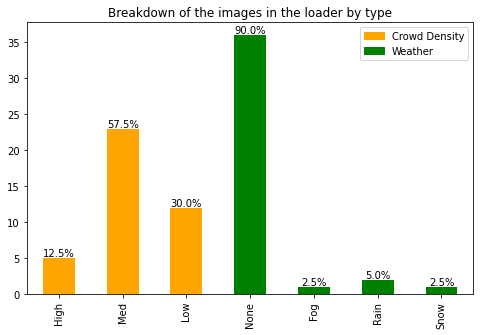

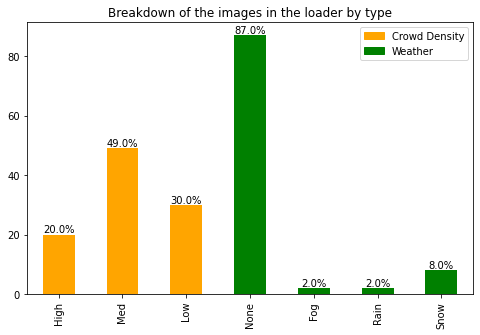

In [17]:
from models.smc.src.evaluate_model import analyse_loader

analyse_loader(data_loader_val)
analyse_loader(data_loader)

In [5]:
import sys
import os
from datetime import datetime
import cv2

sys.path.append('../')

from models.smc.src.utils import save_density_map
from models.smc.src.network import load_net
from models.smc.src.crowd_count import *
from models.smc.src.data_loader import ImageDataLoader


method = 'smc'
dataset_name = 'JHU'
output_dir = f'../output/{method}/saved_models/{dataset_name}'


is_cuda = False  # Determine if we should use the CPU to train or GPU

model = CrowdCounter(is_cuda=is_cuda)  # is_cuda determines if all the input tensors should be converted to cuda tensors
network.weights_normal_init(model, dev=0.01)
model.eval()

# Test data path
test_path = '../data/JHU/test/consolidated'
test_gt_path = '../data/JHU/test/gt'

data_loader_test = ImageDataLoader(test_path, shuffle=False, pre_load=False, num_pool = 2, size=40)

weights_file = os.path.join(output_dir, 'best_MAPE_epoch_100_smc_0.0001.h5')
load_net(weights_file, model)

test_image_0 = data_loader_test.get_test_input(num_pool=2, index=23)
test_image_1 = data_loader_test.get_test_input(num_pool=2, index=18)
test_image_2 = data_loader_test.get_test_input(num_pool=2, index=2)

density_map_0 = model(test_image_0['data'])
density_map_1 = model(test_image_1['data'])
density_map_2 = model(test_image_2['data'])

current_date = datetime.now()
 
# dd/mm/YY H:M:S
cd_string = current_date.strftime("%d/%m/%Y %H:%M:%S")

result = save_density_map(density_map_0.detach().numpy(), output_dir, fname=f'results_0.jpg')
save_density_map(density_map_1.detach().numpy(), output_dir, fname=f'results_1.jpg')
save_density_map(density_map_2.detach().numpy(), output_dir, fname=f'results_2.jpg')

print(result)

True


In [6]:
for i in [4,18,11,8,32,7]:
    test_image = data_loader_test.get_test_input(index=i)
    density_map_test = model(test_image['data'])
    save_density_map(density_map_test.detach().numpy(), output_dir, fname=f'results_{i}.jpg')
    
    im_gray = cv2.imread(os.path.join(output_dir, f'results_{i}.jpg'), cv2.IMREAD_GRAYSCALE)
    im_jet = cv2.applyColorMap(im_gray, cv2.COLORMAP_JET)
    cv2.imwrite(os.path.join(output_dir, f'results_{i}.jpg'), im_jet)

In [ ]:
import cv2

im_gray = cv2.imread(os.path.join(output_dir, 'results_0.jpg'), cv2.IMREAD_GRAYSCALE)
im_jet = cv2.applyColorMap(im_gray, cv2.COLORMAP_JET)
cv2.imwrite(os.path.join(output_dir, 'results_0.jpg'), im_jet)


im_gray = cv2.imread(os.path.join(output_dir, 'results_1.jpg'), cv2.IMREAD_GRAYSCALE)
im_jet = cv2.applyColorMap(im_gray, cv2.COLORMAP_JET)
cv2.imwrite(os.path.join(output_dir, 'results_1.jpg'), im_jet)


im_gray = cv2.imread(os.path.join(output_dir, 'results_2.jpg'), cv2.IMREAD_GRAYSCALE)
im_jet = cv2.applyColorMap(im_gray, cv2.COLORMAP_JET)
cv2.imwrite(os.path.join(output_dir, 'results_2.jpg'), im_jet)


In [ ]:
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

print(test_image_0)
print(test_image_1)
img_0 = test_image_0['data'][0]
img_0 = np.transpose(img_0, (1,2,0))
imgplot = plt.imshow(img_0)

fig, ax = plt.subplots()

plt.subplot(1, 2, 1)
density_map_0_np = density_map_0.detach().numpy()
density_map_0_result = density_map_0_np * 255 / np.max(density_map_0_np)
plt.imshow(density_map_0_result[0][0])
